In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.insert(0, './')
from functions import *
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Identify Vulnerable Tracts


In [187]:
df = pd.read_parquet('Data/Cleaned/after_kriging.parquet')

# remove tracts with no population
tracts_no_ppl = df[df.total_pop<20].GEOID.unique()
df = df[df.GEOID.isin(tracts_no_ppl)==False]


In [61]:
# previous vulnerable logic

# def find_vulnerable_tracts(df, year):
    
#     # limit df to date provided
#     df_yr = df[df.year==year]
    
#     # Median BachelorS
#     threshold_bach = df_yr.percent_bachelors.quantile(.5)
#     # Median POC
#     threshold_white = df_yr.percent_white.quantile(.5)

#     # define eligible column if tract meets all criteria
#     df_yr['vulnerable'] = np.where(
#                                 (df_yr.percent_bachelors<=threshold_bach)&
#                                  (df_yr.percent_white<=threshold_white), 1, 0)
#     vulnerable_tracts = df_yr[df_yr['vulnerable']==1]['full_tract'].unique()

#     return df_yr


In [188]:
# TODO: figure out if dollar amounts in ACS are inflation adjusted or not

def find_vulnerable_tracts(df, year):
    
    # limit df to date provided
    df_yr = df[df.year==year]
    
    # Median Income
    threshold_income = df_yr.med_income.quantile(.5)
    # Median POC
    threshold_white = df_yr.percent_white.quantile(.5)

    # define eligible column if tract meets all criteria
    df_yr['vulnerable'] = np.where(
                                (df_yr.med_income<=threshold_income)&
                                 (df_yr.percent_white<=threshold_white), 1, 0)
    vulnerable_tracts = df_yr[df_yr['vulnerable']==1]['full_tract'].unique()

    return df_yr

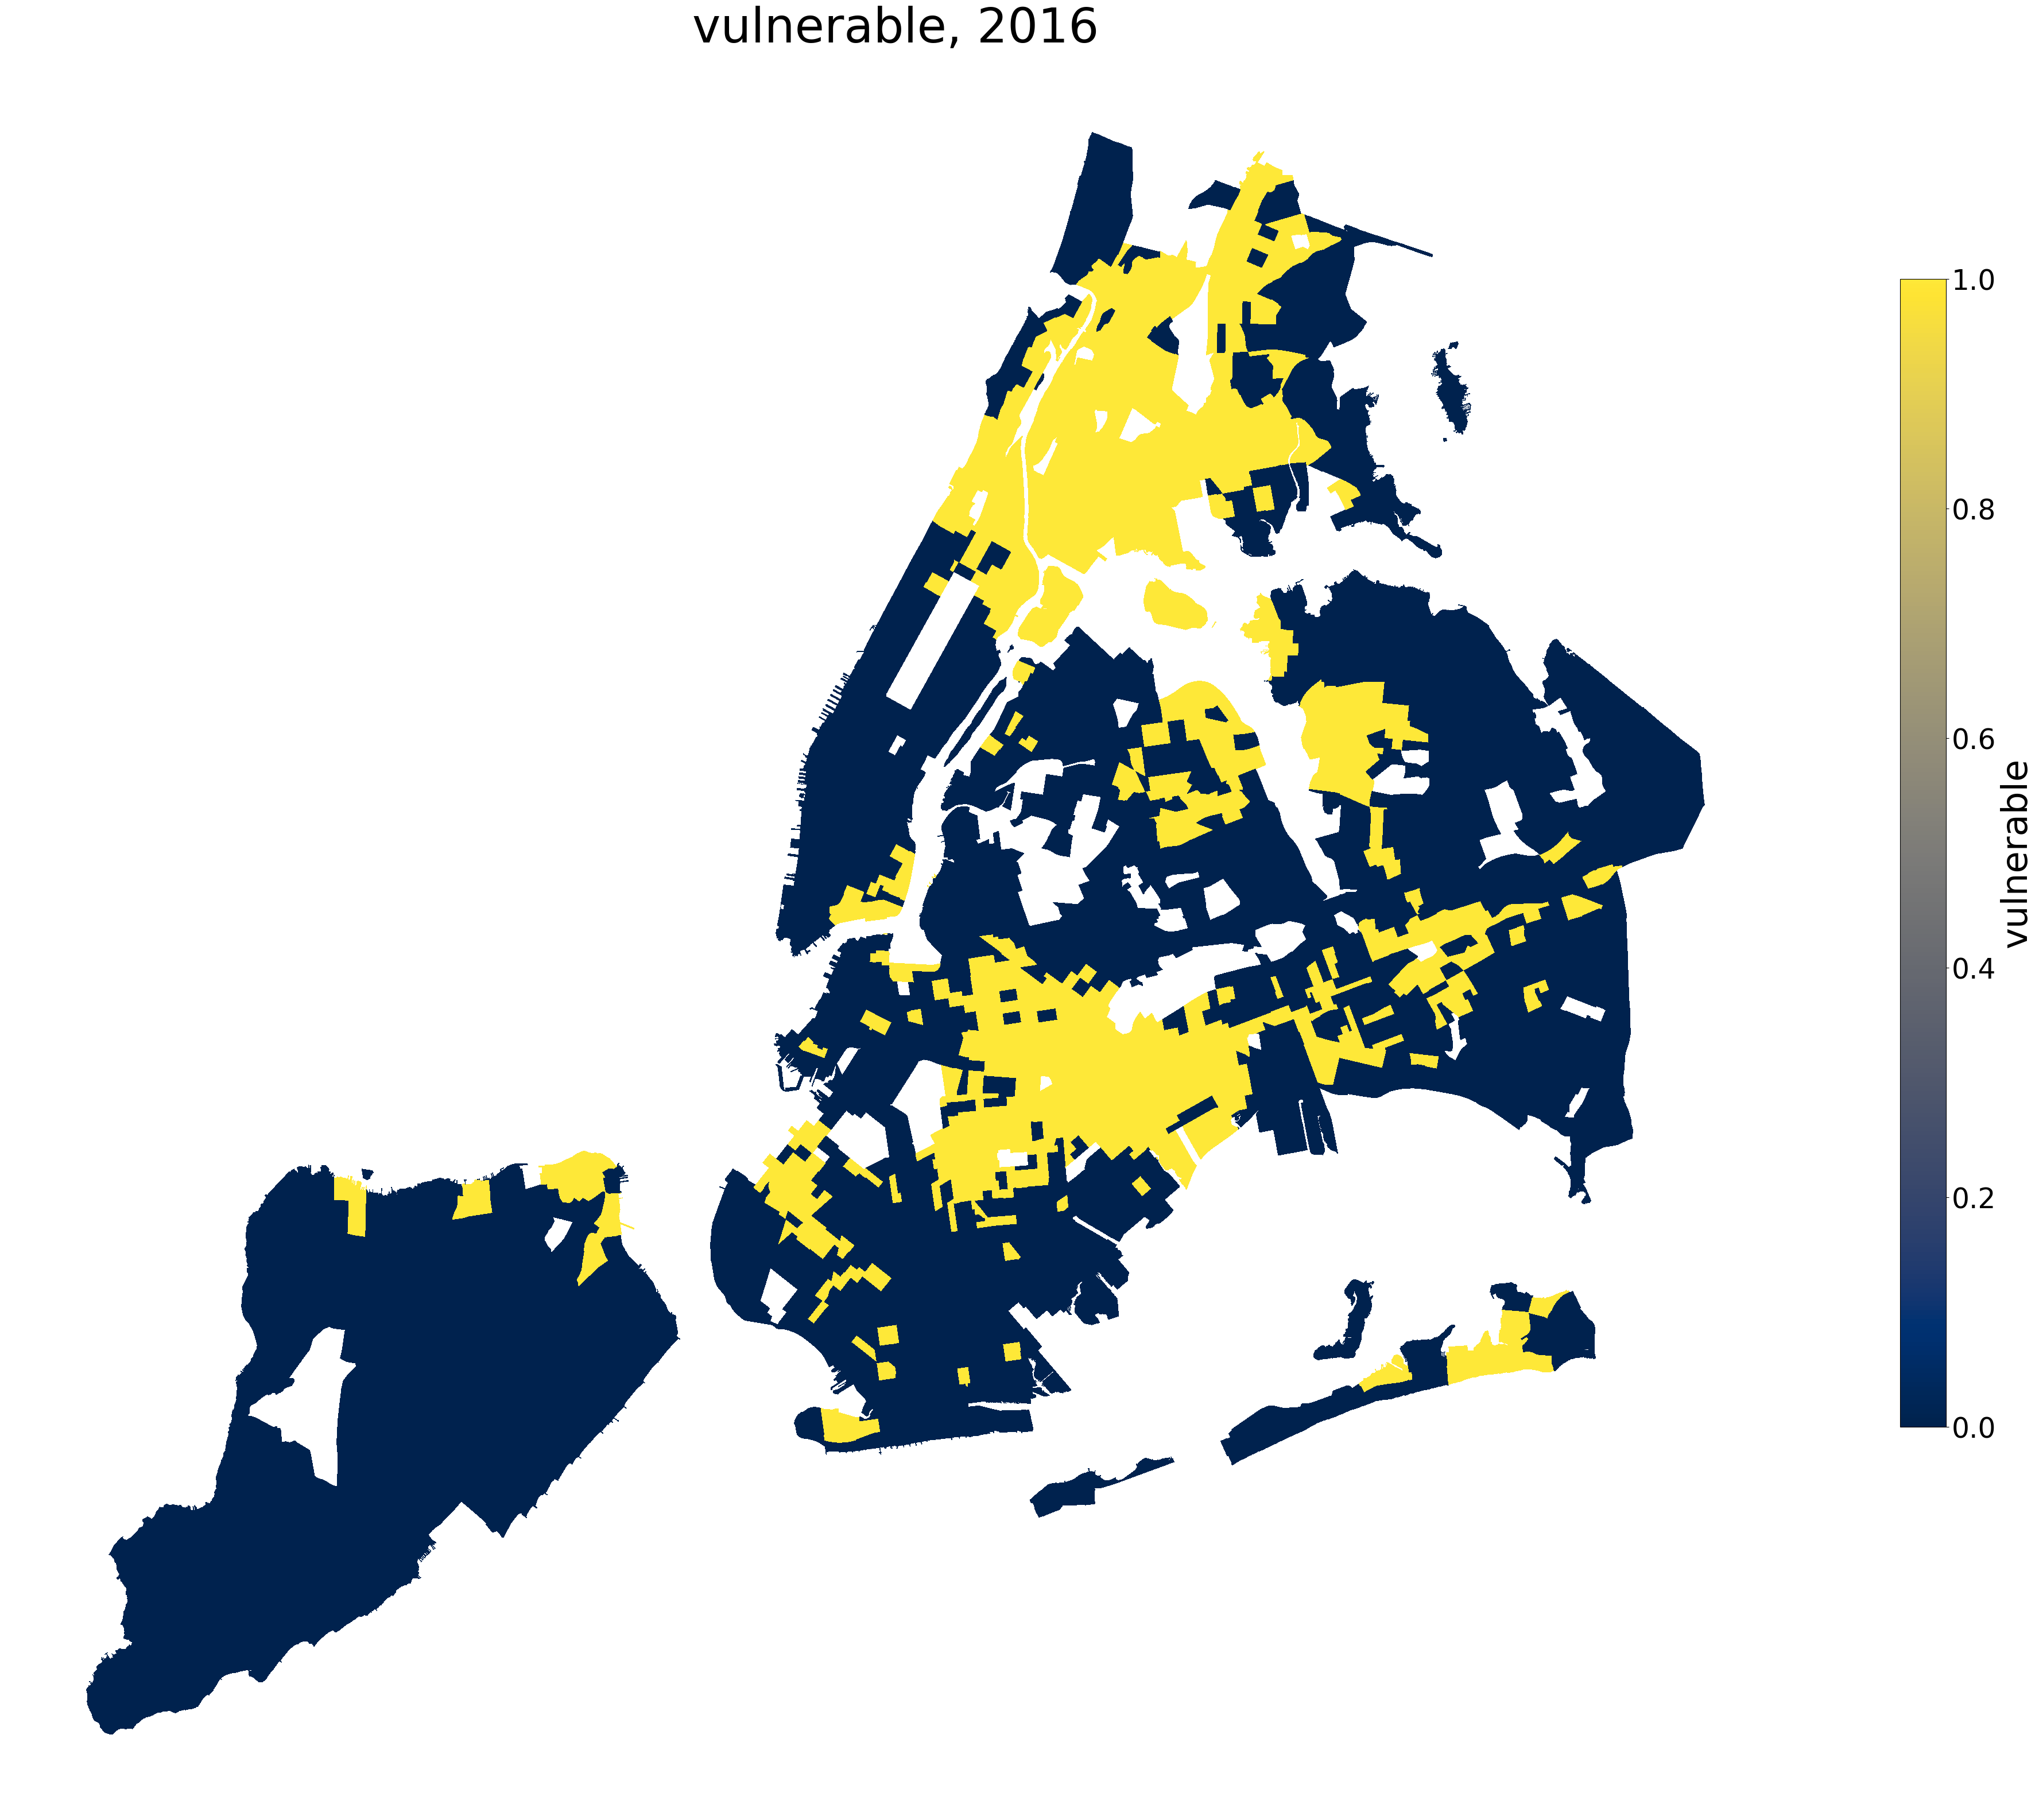

In [63]:
# Test out the function

df_16 = find_vulnerable_tracts(df, '2016')
choropleth(df_16, 'vulnerable', ['2016'], cmap='cividis')

# Identify Gentrified Tracts
We look at percent changes in decade prior to datestamp


In [64]:
def find_gentrified_tracts(df, pred_year):
    df = df[df.year.astype(int) >= int(pred_year)-10]  # limit df to the 10 years prior
    
    # fill zeros with nan so we can calculate percent change
    df.replace(0, np.nan, inplace=True)
    
    # get average percent change over decade
    pct_chg = df.drop(['NAME','year','full_tract', 'vulnerable'], axis=1).groupby('GEOID').agg(lambda x: x.pct_change().mean())
    pct_chg.dropna(how='all', inplace=True)
    pct_chg.fillna(0, inplace=True)

    # Set thresholds. consider it gentrifying if % change is greater than median for region (of all tracts, not just vulnerable ones)

    # Median Bachelors
    threshold_bach = pct_chg.percent_bachelors.quantile(.5)
    # Median income
    threshold_income = pct_chg.med_income.quantile(.5)
    # Median Rent
    threshold_rent = pct_chg.med_rent_acs.quantile(.5)
    # Median POC
    threshold_white = pct_chg.percent_white.quantile(.5)

    # define gentrified column if tract meets all criteria
    pct_chg['gentrified'] = np.where(
                                 (((pct_chg.percent_bachelors>=threshold_bach)&(pct_chg.med_income>=threshold_income)) |
                                 ((pct_chg.percent_bachelors>=threshold_bach)&(pct_chg.med_rent_acs>=threshold_rent)) |
                                 ((pct_chg.med_income>=threshold_income)&(pct_chg.med_rent_acs>=threshold_rent))) &
                                 (pct_chg.percent_white>=threshold_white), 1, 0)  # 1 is gentrified, 0 is not
    
    return(pct_chg[['gentrified']].reset_index())
    

## Corroborate labels with UDP 2016

In [66]:
# labels_16 = pd.read_excel("Data/Raw/udp_labels_2016.xlsx")
# df_16 = find_vulnerable_tracts(df, '2016')

# labels_16['udp_labels'] = np.select([labels_16['Type_1.19'].isin(['LI - At Risk of Gentrification',
#                                    'LI - Ongoing Gentrification']),
#                                         labels_16['Type_1.19'].isin(['LI - Ongoing Displacement of Low-Income Households',
#        'LI - Not Losing Low-Income Households']),
#                                         labels_16['Type_1.19'].isin(['MHI - Advanced Gentrification',
#        'MHI - Ongoing Exclusion', 'MHI - Stable Exclusion',
#        'Missing Data', 'VHI - Super Gentrification or Exclusion'])],
#                                         [2,1,0], 
#                                         -1)
# labels_16['geoid'] = labels_16['geoid'].astype(str)
# udp_df = df_16.merge(labels_16, left_on='GEOID', right_on='geoid')

# choropleth(udp_df, 'udp_labels', ['2016'], cmap='plasma')

# Construct Labels For Training
### Train:
- train on features 2010-2016 to predict gentrification status in 2020 (labels from 2020, eligible tracts from 2010)
- 2011-2017 --> 2021
- 2012-2018
- 2013-2019
### Preds:
- use features 2014-2020 to predict gentrification status in 2024 (no labels, eligible tracts are taken from 2014)
- 2015-2021 --> 2025
- 2016-2022
- 2017-2023


In [67]:
def construct_labels(df, yr_vulnerable, yr_gentrified, pred_set=False):
    temp_df = df.copy()
    
    # Identify Vulnerable Tracts
    vul_tracts_df = find_vulnerable_tracts(temp_df, yr_vulnerable)
    vul_tracts = vul_tracts_df[vul_tracts_df['vulnerable']==1]['full_tract']
    temp_df['vulnerable'] = np.where(temp_df.full_tract.isin(vul_tracts), 1,0)

    if not pred_set:
        # Identify Gentrified Tracts (has to be a vulnerable tract)
        gent_tracts_df = find_gentrified_tracts(temp_df, yr_gentrified)
        gent_tracts = gent_tracts_df[gent_tracts_df['gentrified']==1]['GEOID']
        temp_df['gentrified'] = np.where((temp_df.GEOID.isin(gent_tracts)), 1,0)
    else:
        temp_df['gentrified'] = 0

    # Create label based on vulnerable and gentrified tracts
    temp_df['label'] = np.select([((temp_df['gentrified']==1) & (temp_df['vulnerable']==1)),  # gentrified if also vulnerable
                                  (temp_df['vulnerable']==0),  # if not vulnerable it cannot be gentrified
                                  ((temp_df['gentrified']==0) & (temp_df['vulnerable']==1))],  # can be vulnerable but not gentrified
                      [2,0,1],
                      -1)
    temp_df['pred_year'] = yr_gentrified
    return temp_df

In [182]:
# labels_2020 = construct_labels(df, '2010','2020')
# labels_2021 = construct_labels(df, '2011','2021')
# labels_2022 = construct_labels(df, '2012','2022')
# labels_2023 = construct_labels(df, '2013','2023')
# labels_2024 = construct_labels(df, '2014','2024', pred_set=True)
# labels_2025 = construct_labels(df, '2015','2025', pred_set=True)
# labels_2026 = construct_labels(df, '2016','2026', pred_set=True)
# labels_2027 = construct_labels(df, '2017','2027', pred_set=True)  # get vulnerable tracts for the pred set

labels = pd.concat([labels_2020,labels_2021,labels_2022,labels_2023,labels_2024,labels_2025,labels_2026,labels_2027])
labels = labels[['GEOID','label','vulnerable','gentrified','pred_year']].drop_duplicates()
labels_2020.label.value_counts()


label
0    20650
1     6160
2     4354
Name: count, dtype: int64

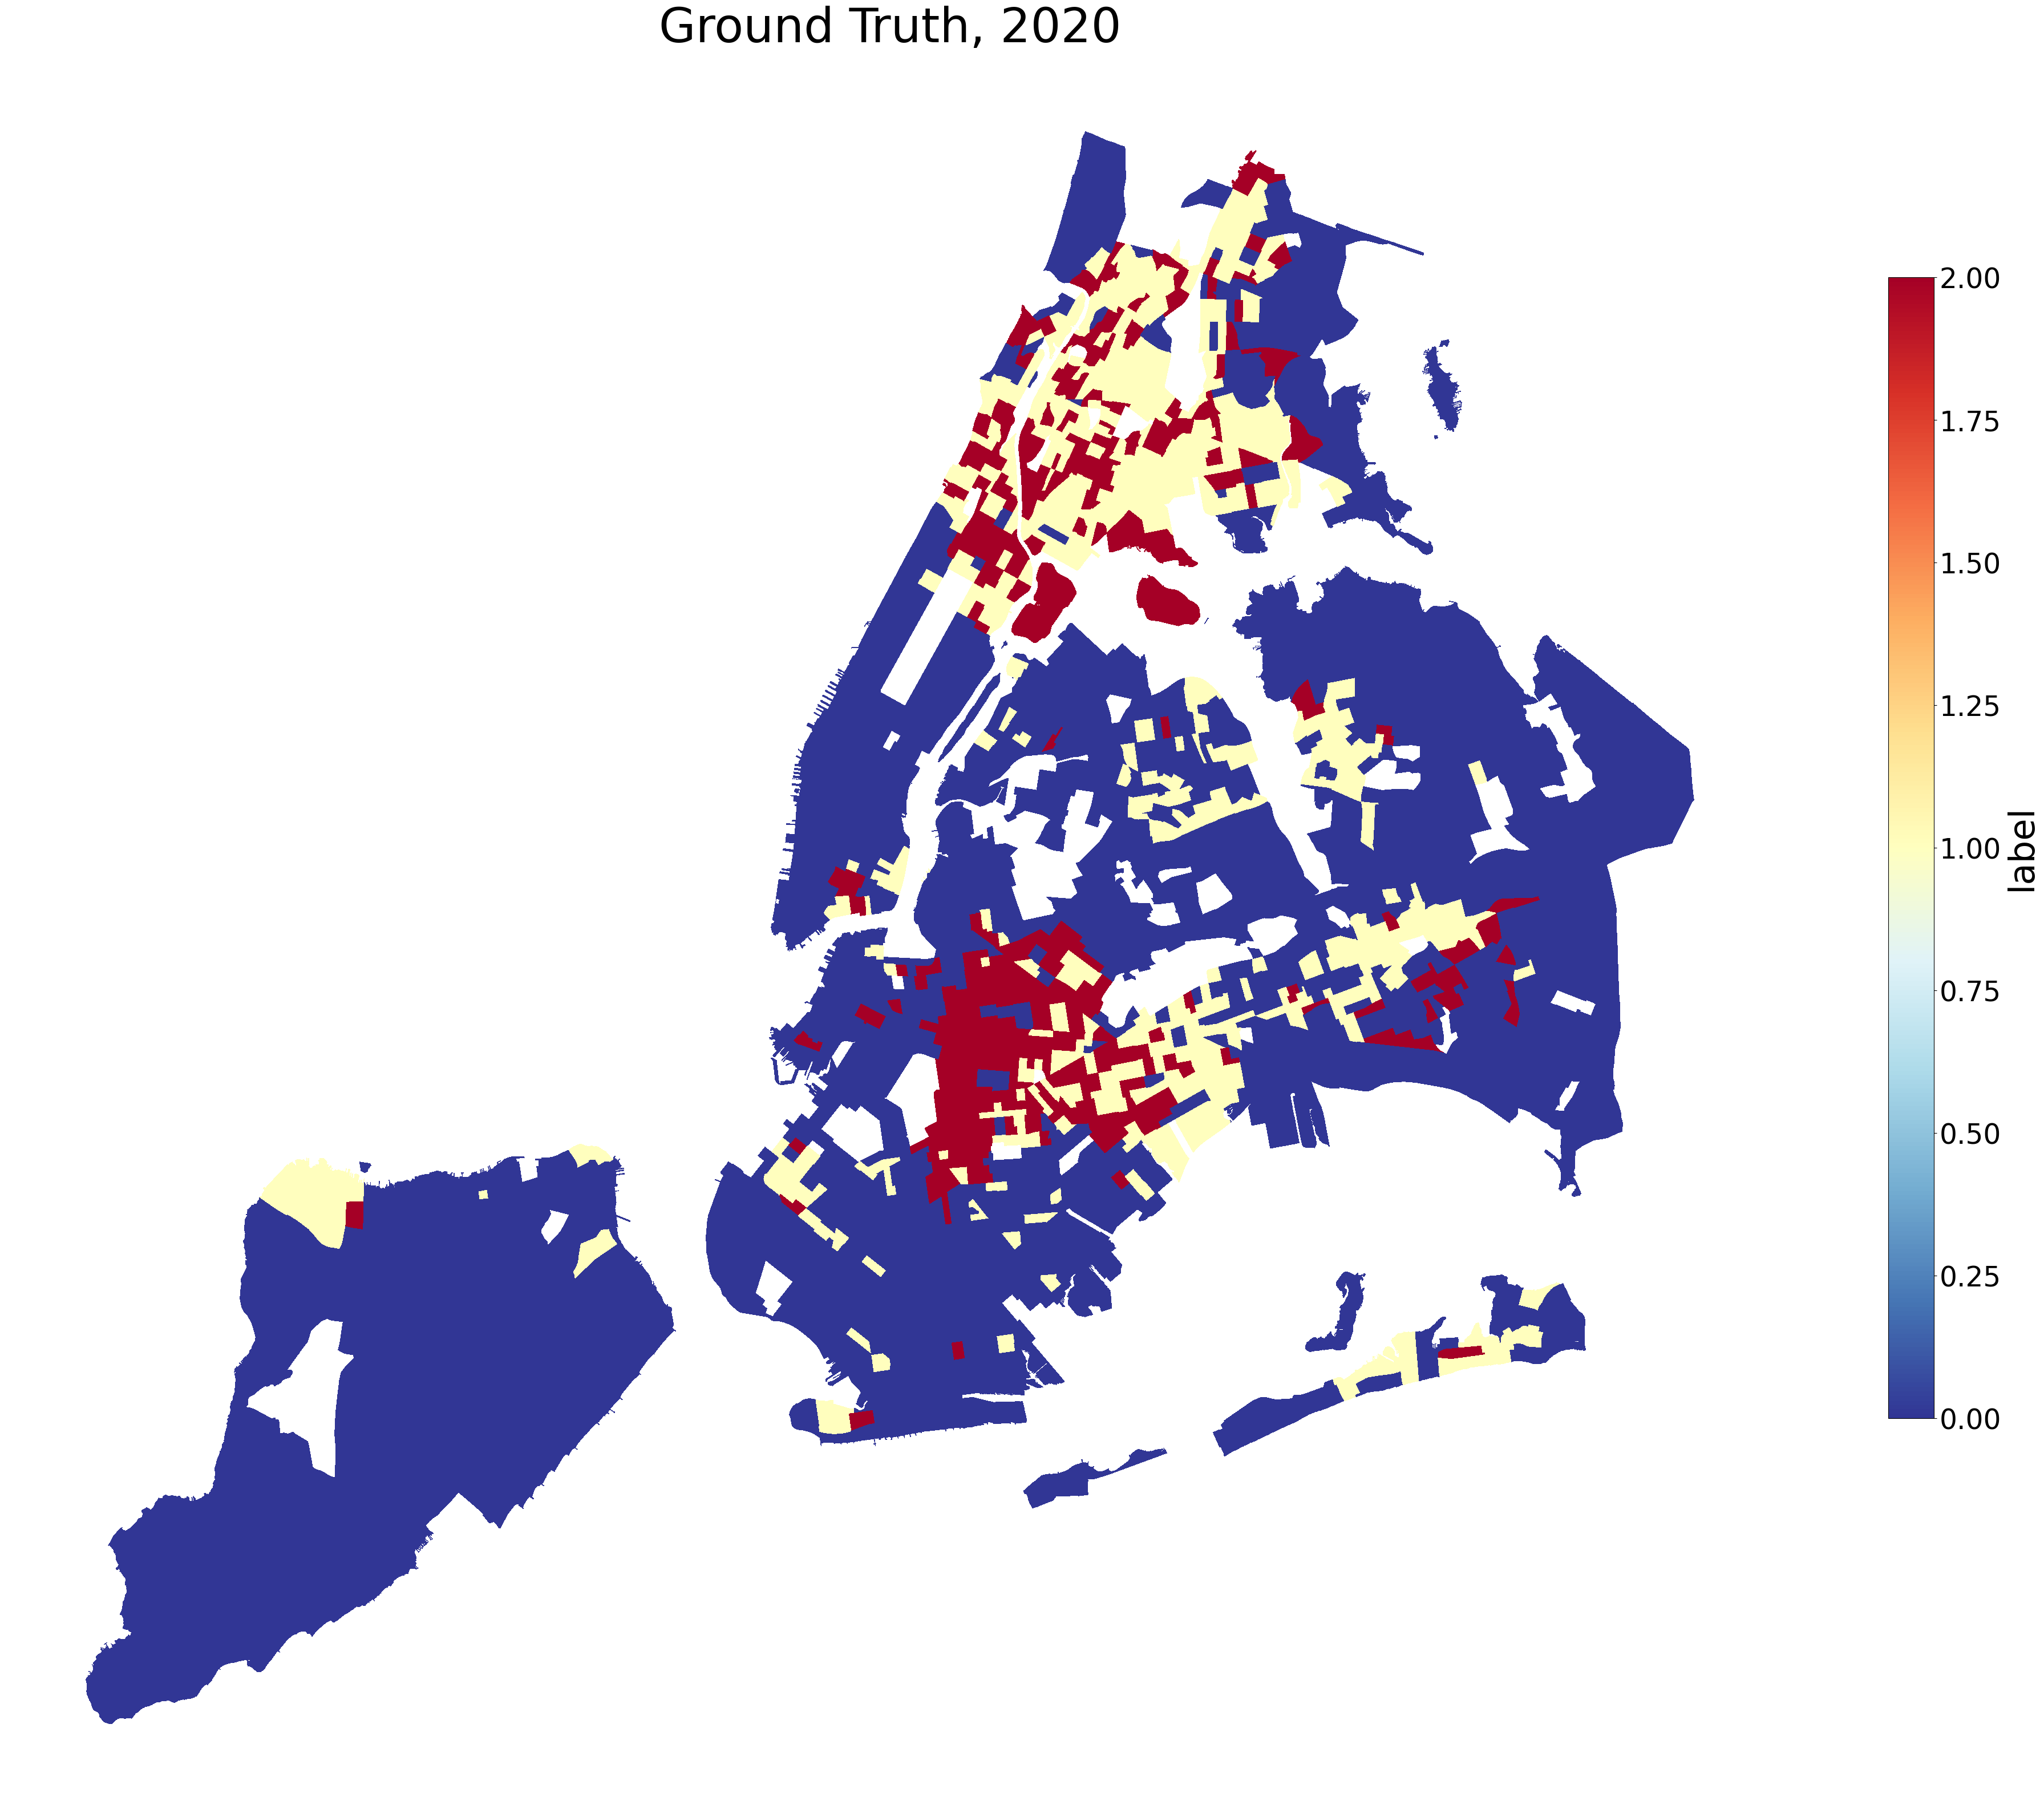

In [196]:
# visualize
choropleth(labels_2020, 'label', ['2020'], cmap='RdYlBu_r', title='Ground Truth', save_img=True)

## Flag for Ever-Gentrified
Will use this during feature engineering to compute our spatial-lag feature

In [183]:
yr_list = []
for pred_year in ['2021','2022','2023','2024','2025','2026','2027']:
    ever_gentrified = labels[labels.pred_year < pred_year].groupby('GEOID')['gentrified'].sum().reset_index()
    ever_gentrified['pred_year']= pred_year
    yr_list.append(ever_gentrified)

ever_gentrified = pd.concat(yr_list)
ever_gentrified['ever_gentrified'] = ever_gentrified['gentrified'].astype(bool).astype(int)
ever_gentrified

,GEOID,gentrified,pred_year,ever_gentrified
0,36005000100,1,2021,1
1,36005000200,1,2021,1
2,36005000400,0,2021,0
3,36005001600,0,2021,0
4,36005001901,1,2021,1
...,...,...,...,...
2221,36085030301,1,2027,1
2222,36085030302,0,2027,0
2223,36085031901,4,2027,1
2224,36085031902,0,2027,0


In [184]:
labels = labels.merge(ever_gentrified[['GEOID','pred_year','ever_gentrified']], on=['GEOID','pred_year'], how='left')
labels['ever_gentrified'] = labels['ever_gentrified'].fillna(-1)
labels['ever_gentrified'] = labels['ever_gentrified'].astype(int)
labels

,GEOID,label,vulnerable,gentrified,pred_year,ever_gentrified
0,36005000100,2,1,1,2020,-1
1,36005000200,0,0,1,2020,-1
2,36005000400,0,0,0,2020,-1
3,36005001600,1,1,0,2020,-1
4,36005001901,2,1,1,2020,-1
...,...,...,...,...,...,...
17803,36085030301,0,0,0,2027,1
17804,36085030302,0,0,0,2027,0
17805,36085031901,1,1,0,2027,1
17806,36085031902,1,1,0,2027,0


In [185]:
# labels.to_parquet('Data/Cleaned/labels_may5.parquet')


# Track Displacement

In [197]:
def find_declining_tracts(df, pred_year):
    df = df[df.year.astype(int) >= int(pred_year)-10]  # limit df to the 10 years prior
    
    # fill zeros with nan so we can calculate percent change
    df.replace(0, np.nan, inplace=True)
    
    # get average percent change over decade
    pct_chg = df.drop(['NAME','year','full_tract'], axis=1).groupby('GEOID').agg(lambda x: x.pct_change().mean())
    pct_chg.dropna(how='all', inplace=True)
    pct_chg.fillna(0, inplace=True)
    
    # Set thresholds. consider it displaced if % change is less than median for region (of all tracts, not just vulnerable ones)

    # Median Bachelors
    threshold_bach = pct_chg.percent_bachelors.quantile(.3)
    # Median income
    threshold_income = pct_chg.med_income.quantile(.3)
    # Median Rent
    threshold_rent = pct_chg.med_rent_acs.quantile(.3)
    # Median POC
    threshold_white = pct_chg.percent_white.quantile(.3)

    # define gentrified column if tract meets all criteria
    pct_chg['declining'] = np.where(
                                 (((pct_chg.percent_bachelors<=threshold_bach)&(pct_chg.med_income<=threshold_income)) |
                                 ((pct_chg.percent_bachelors<=threshold_bach)&(pct_chg.med_rent_acs<=threshold_rent)) |
                                 ((pct_chg.med_income<=threshold_income)&(pct_chg.med_rent_acs<=threshold_rent))) &
                                 (pct_chg.percent_white<=threshold_white), 1, 0)  # 1 is de-gentrified, 0 is not

    pct_chg['year'] = pred_year
    
    return(pct_chg[['declining', 'year']].reset_index())
    

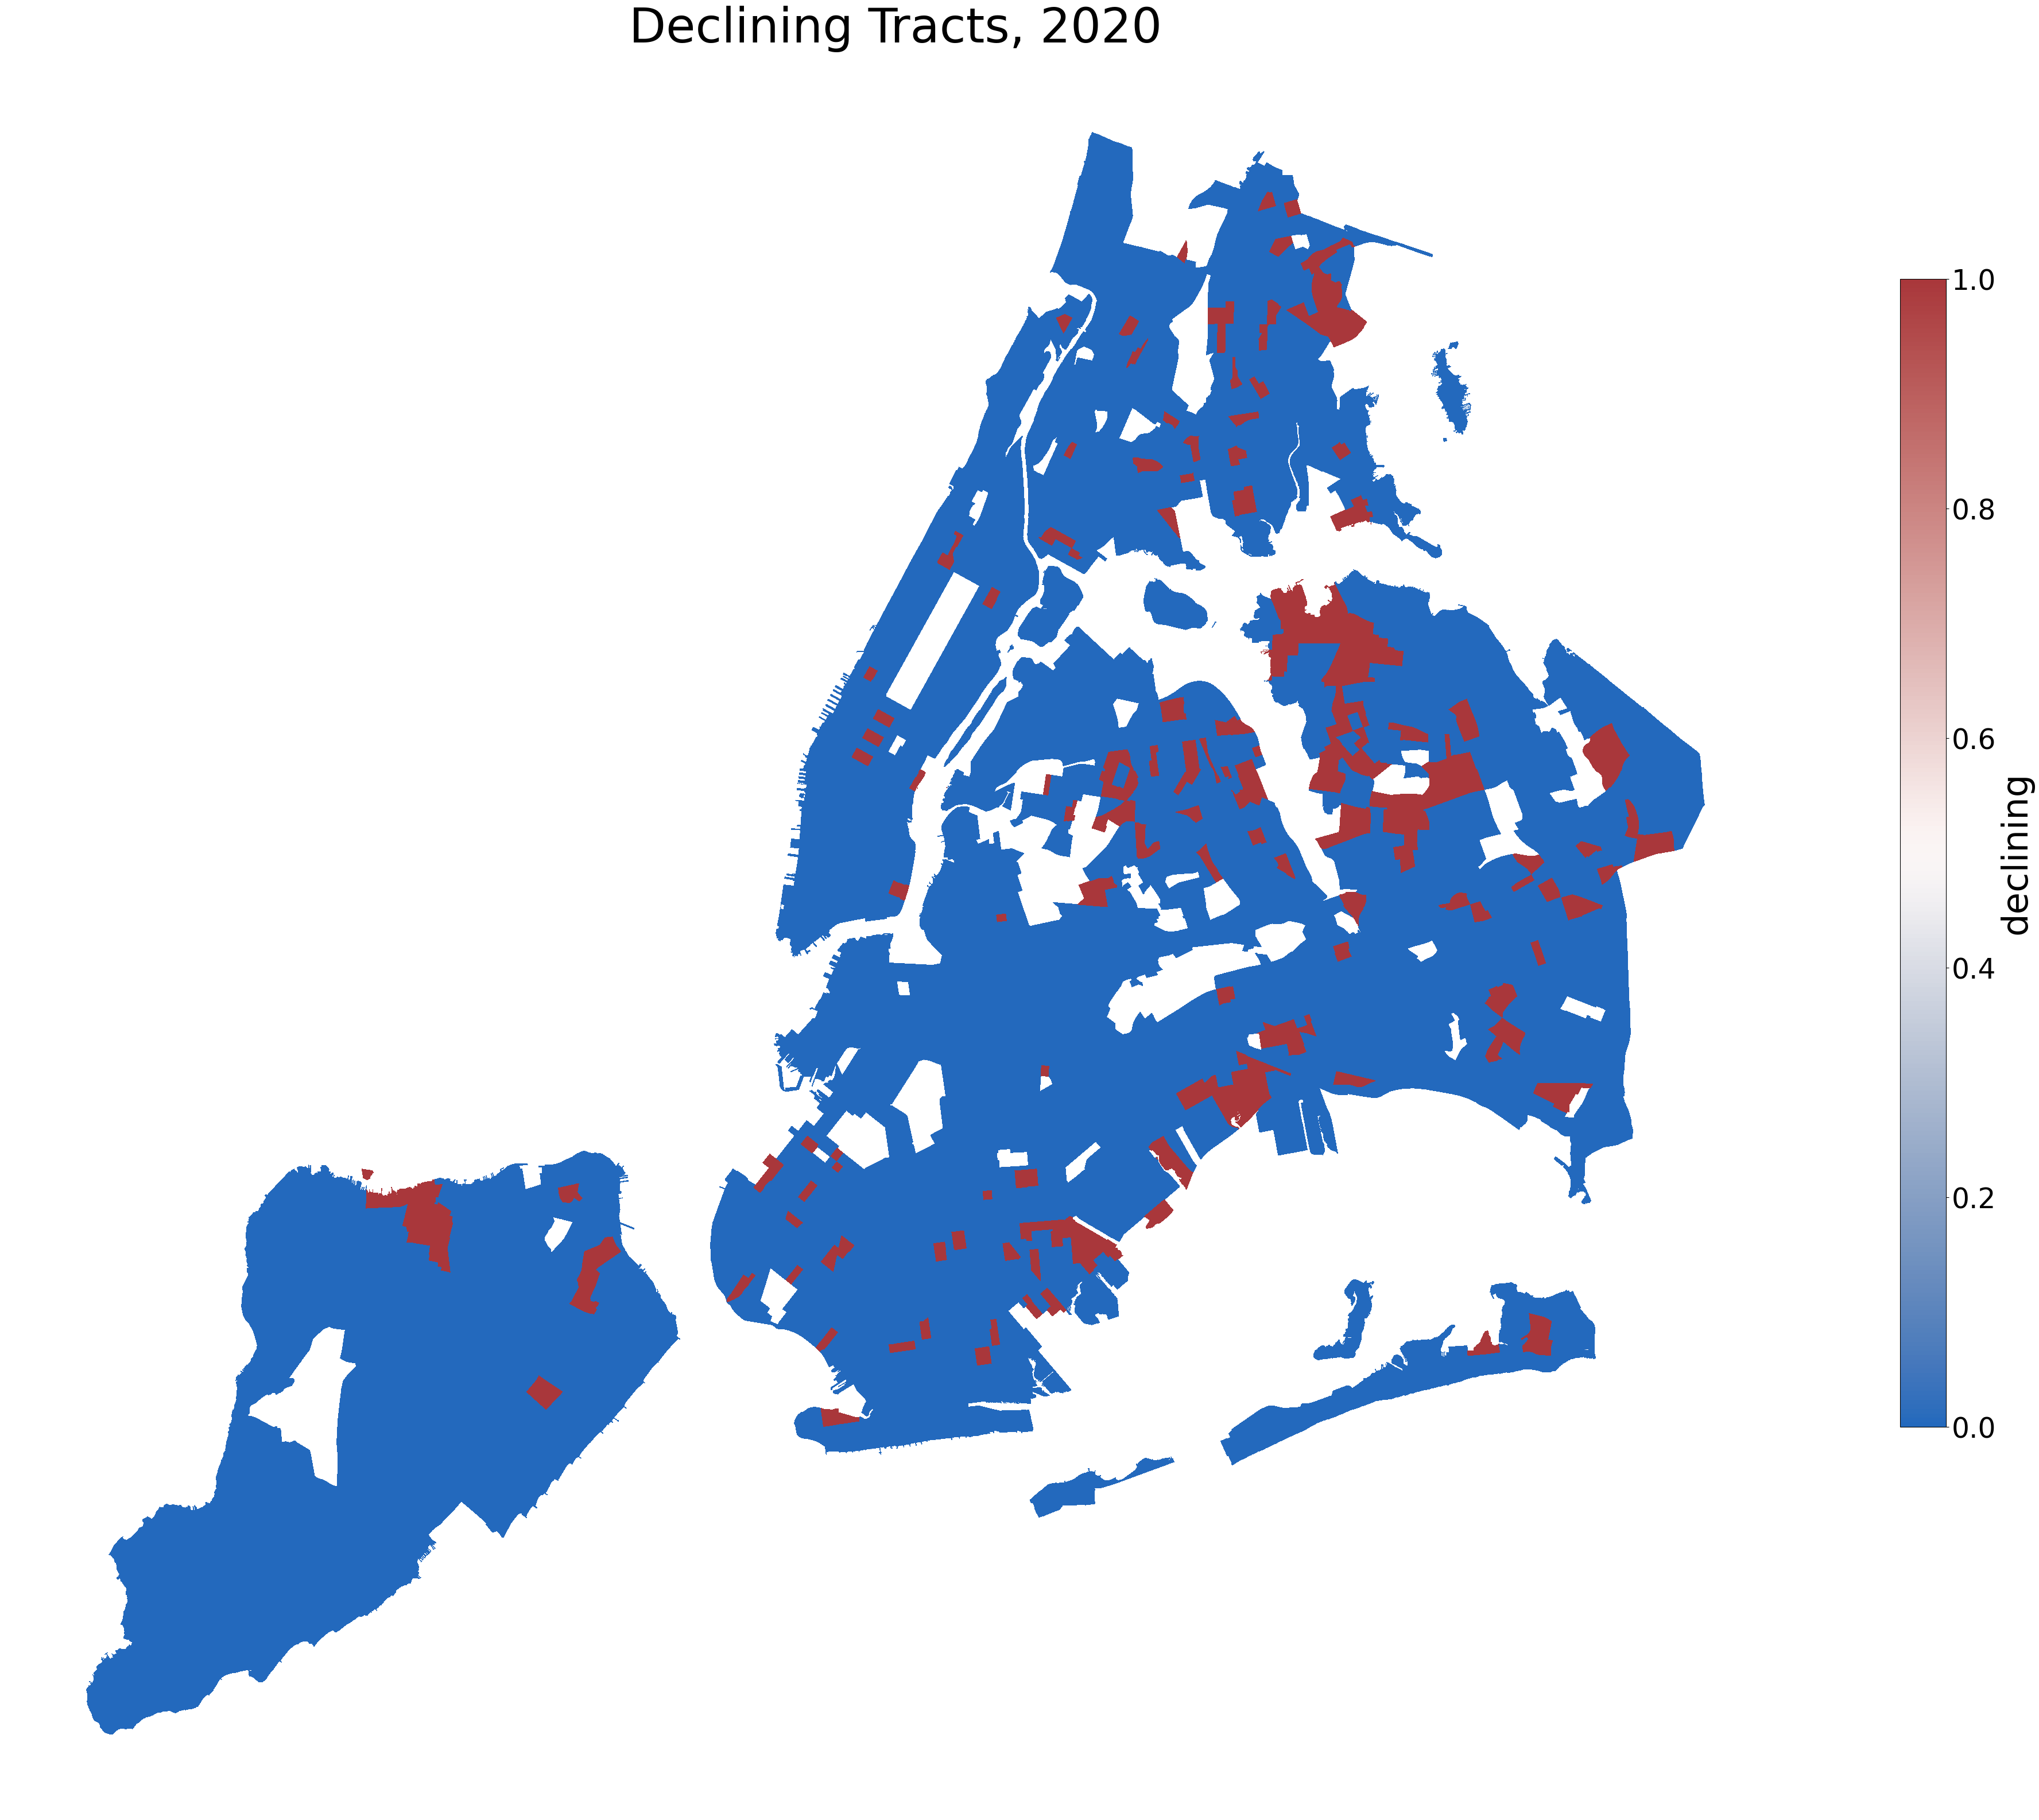

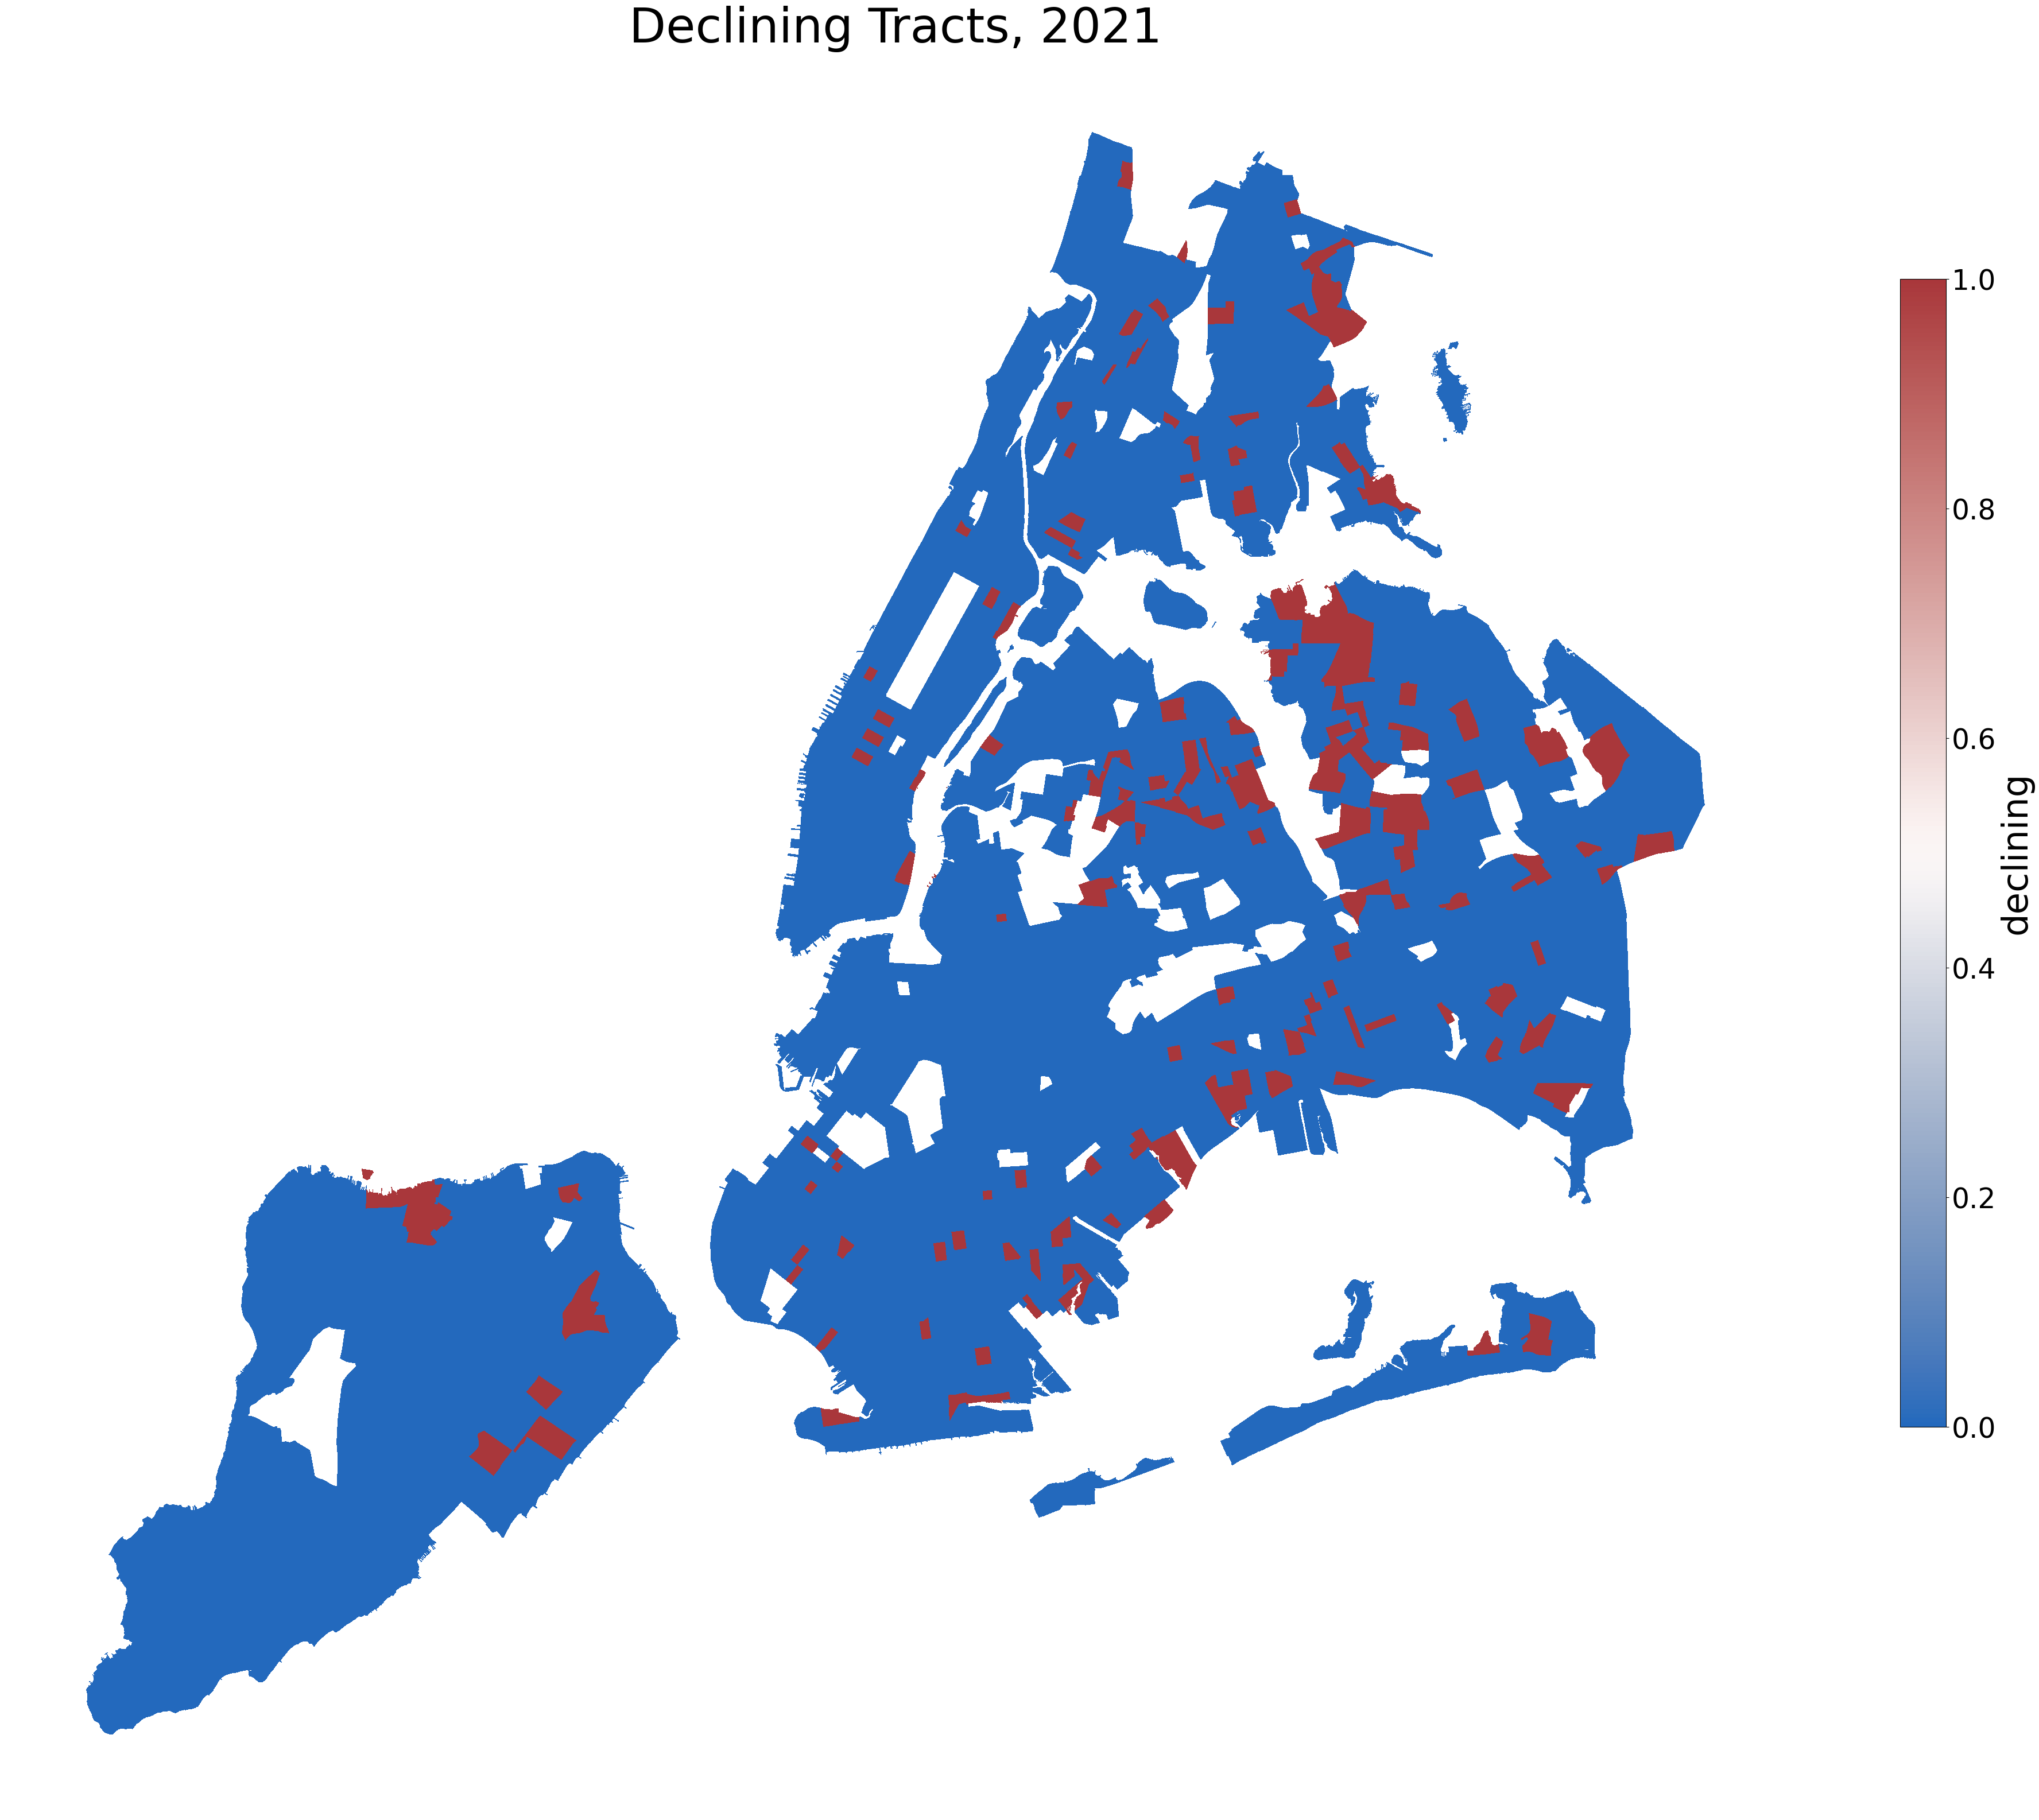

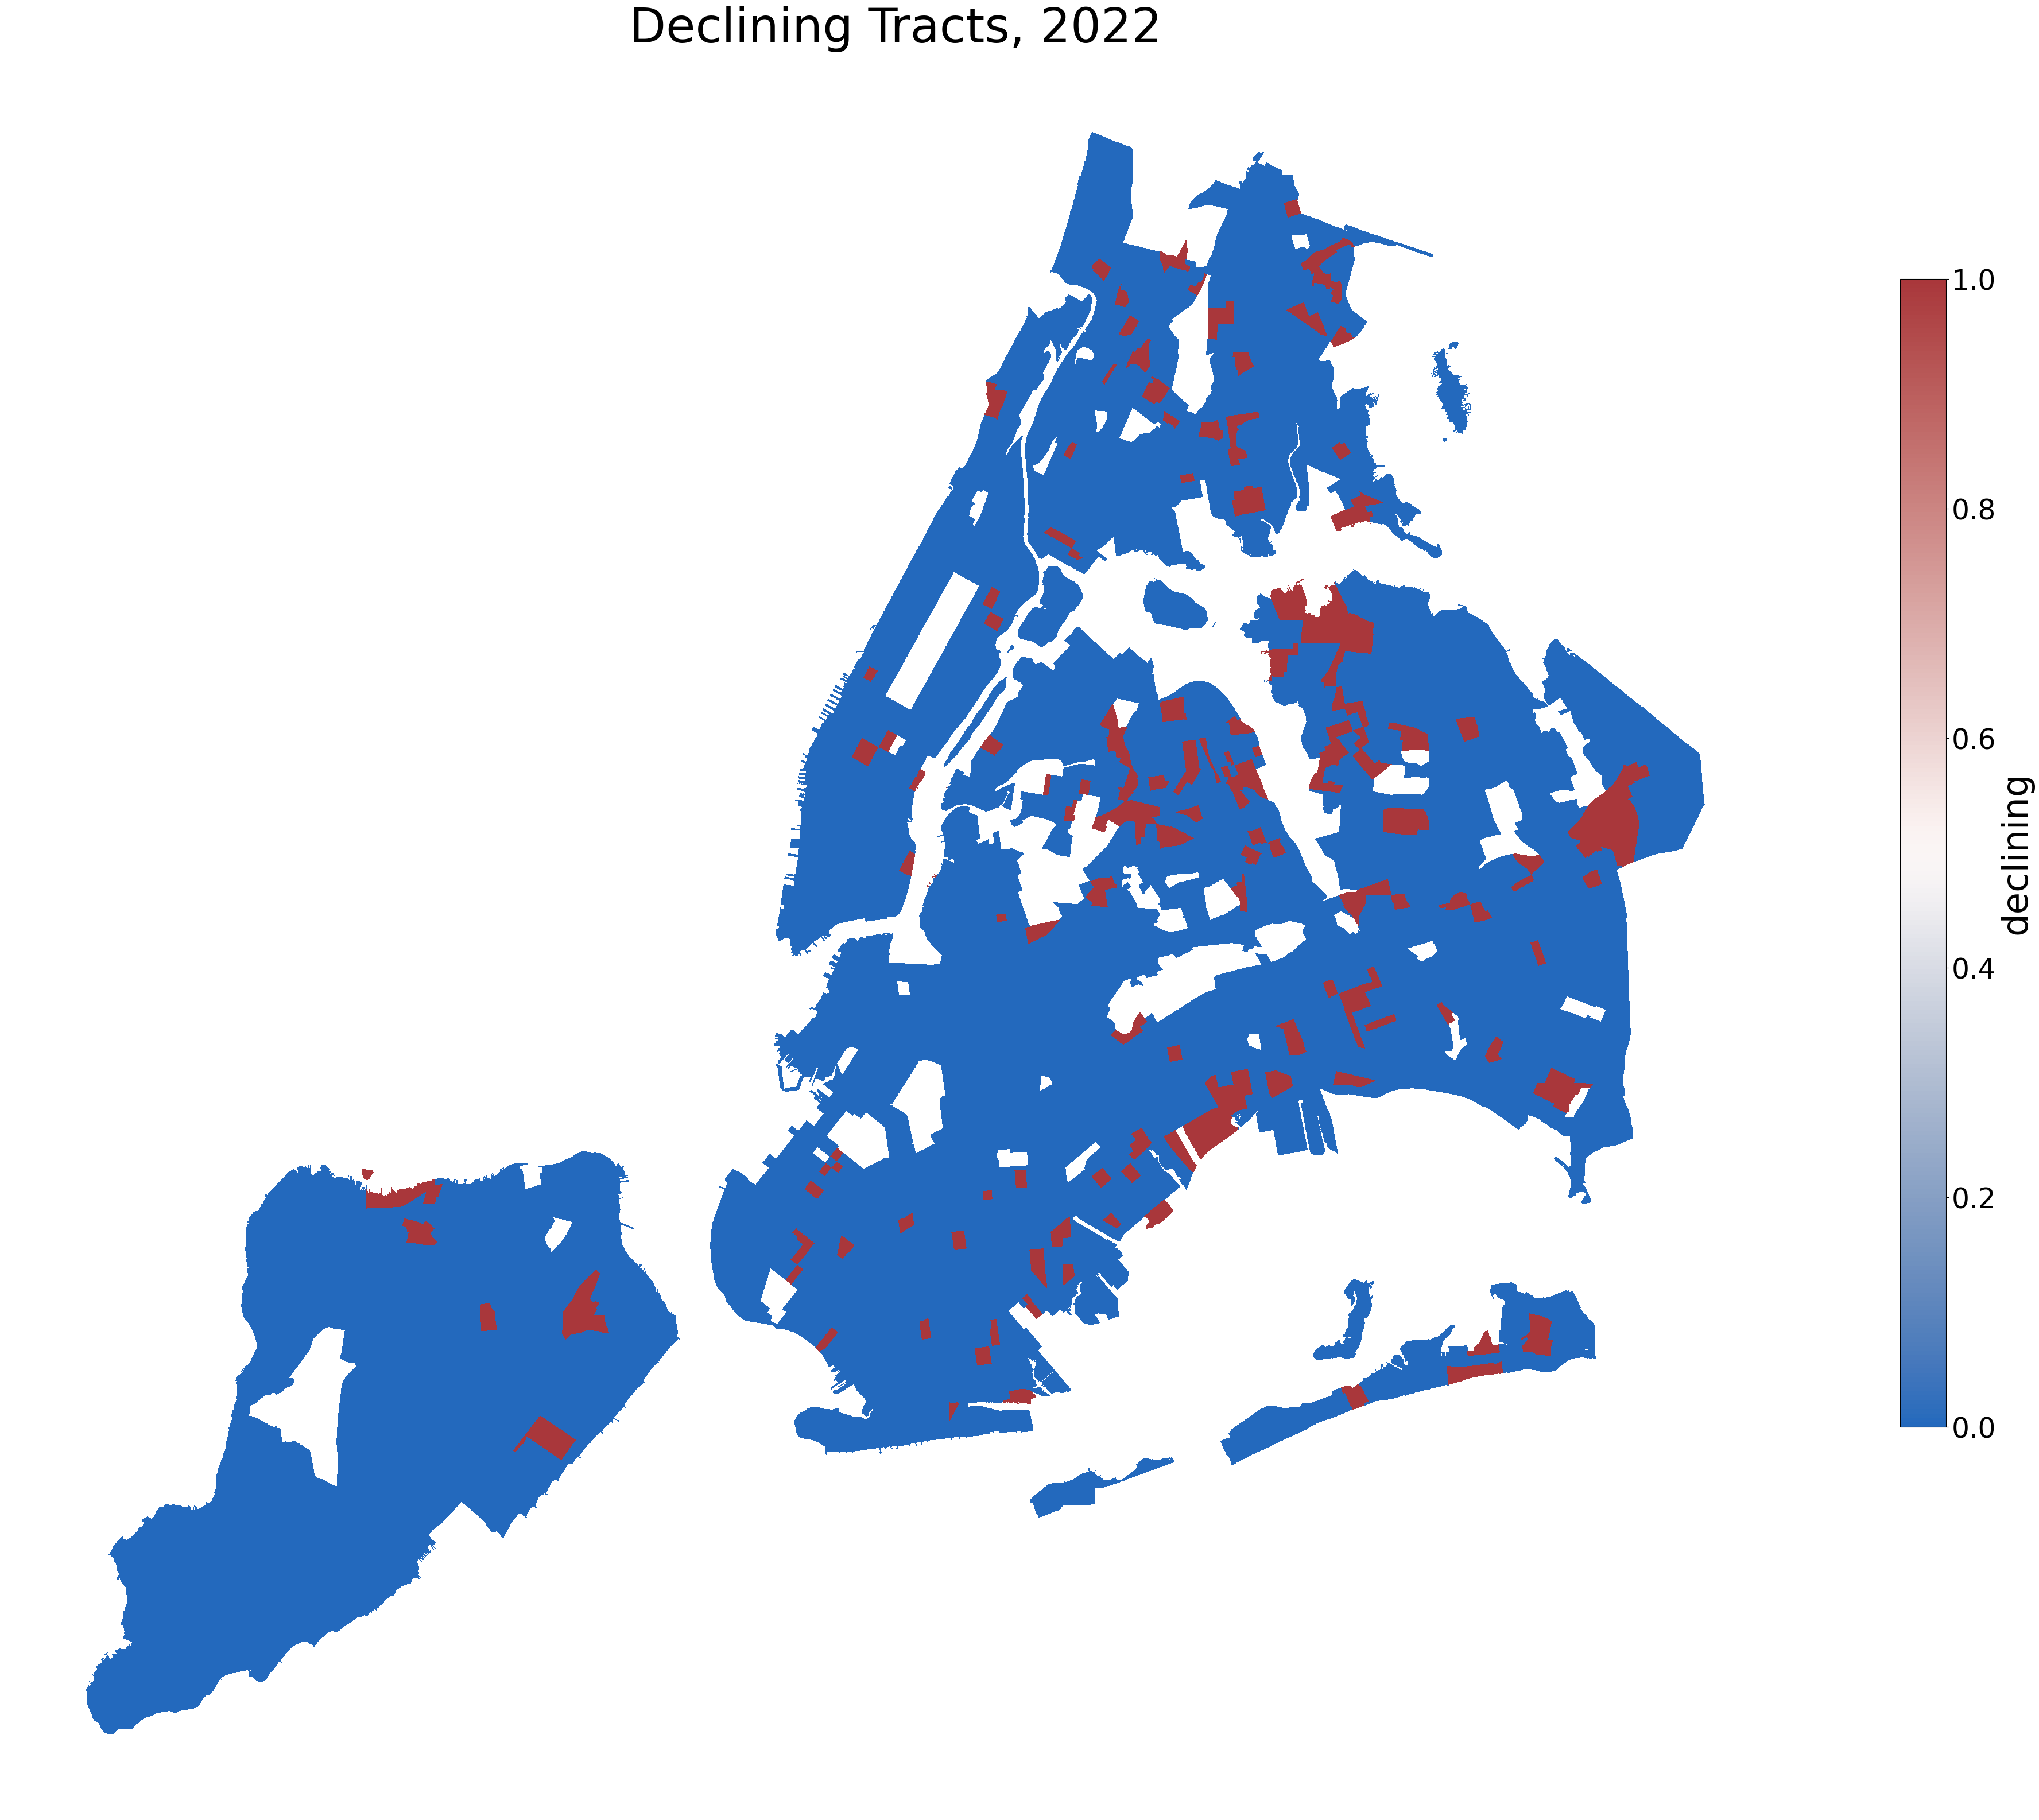

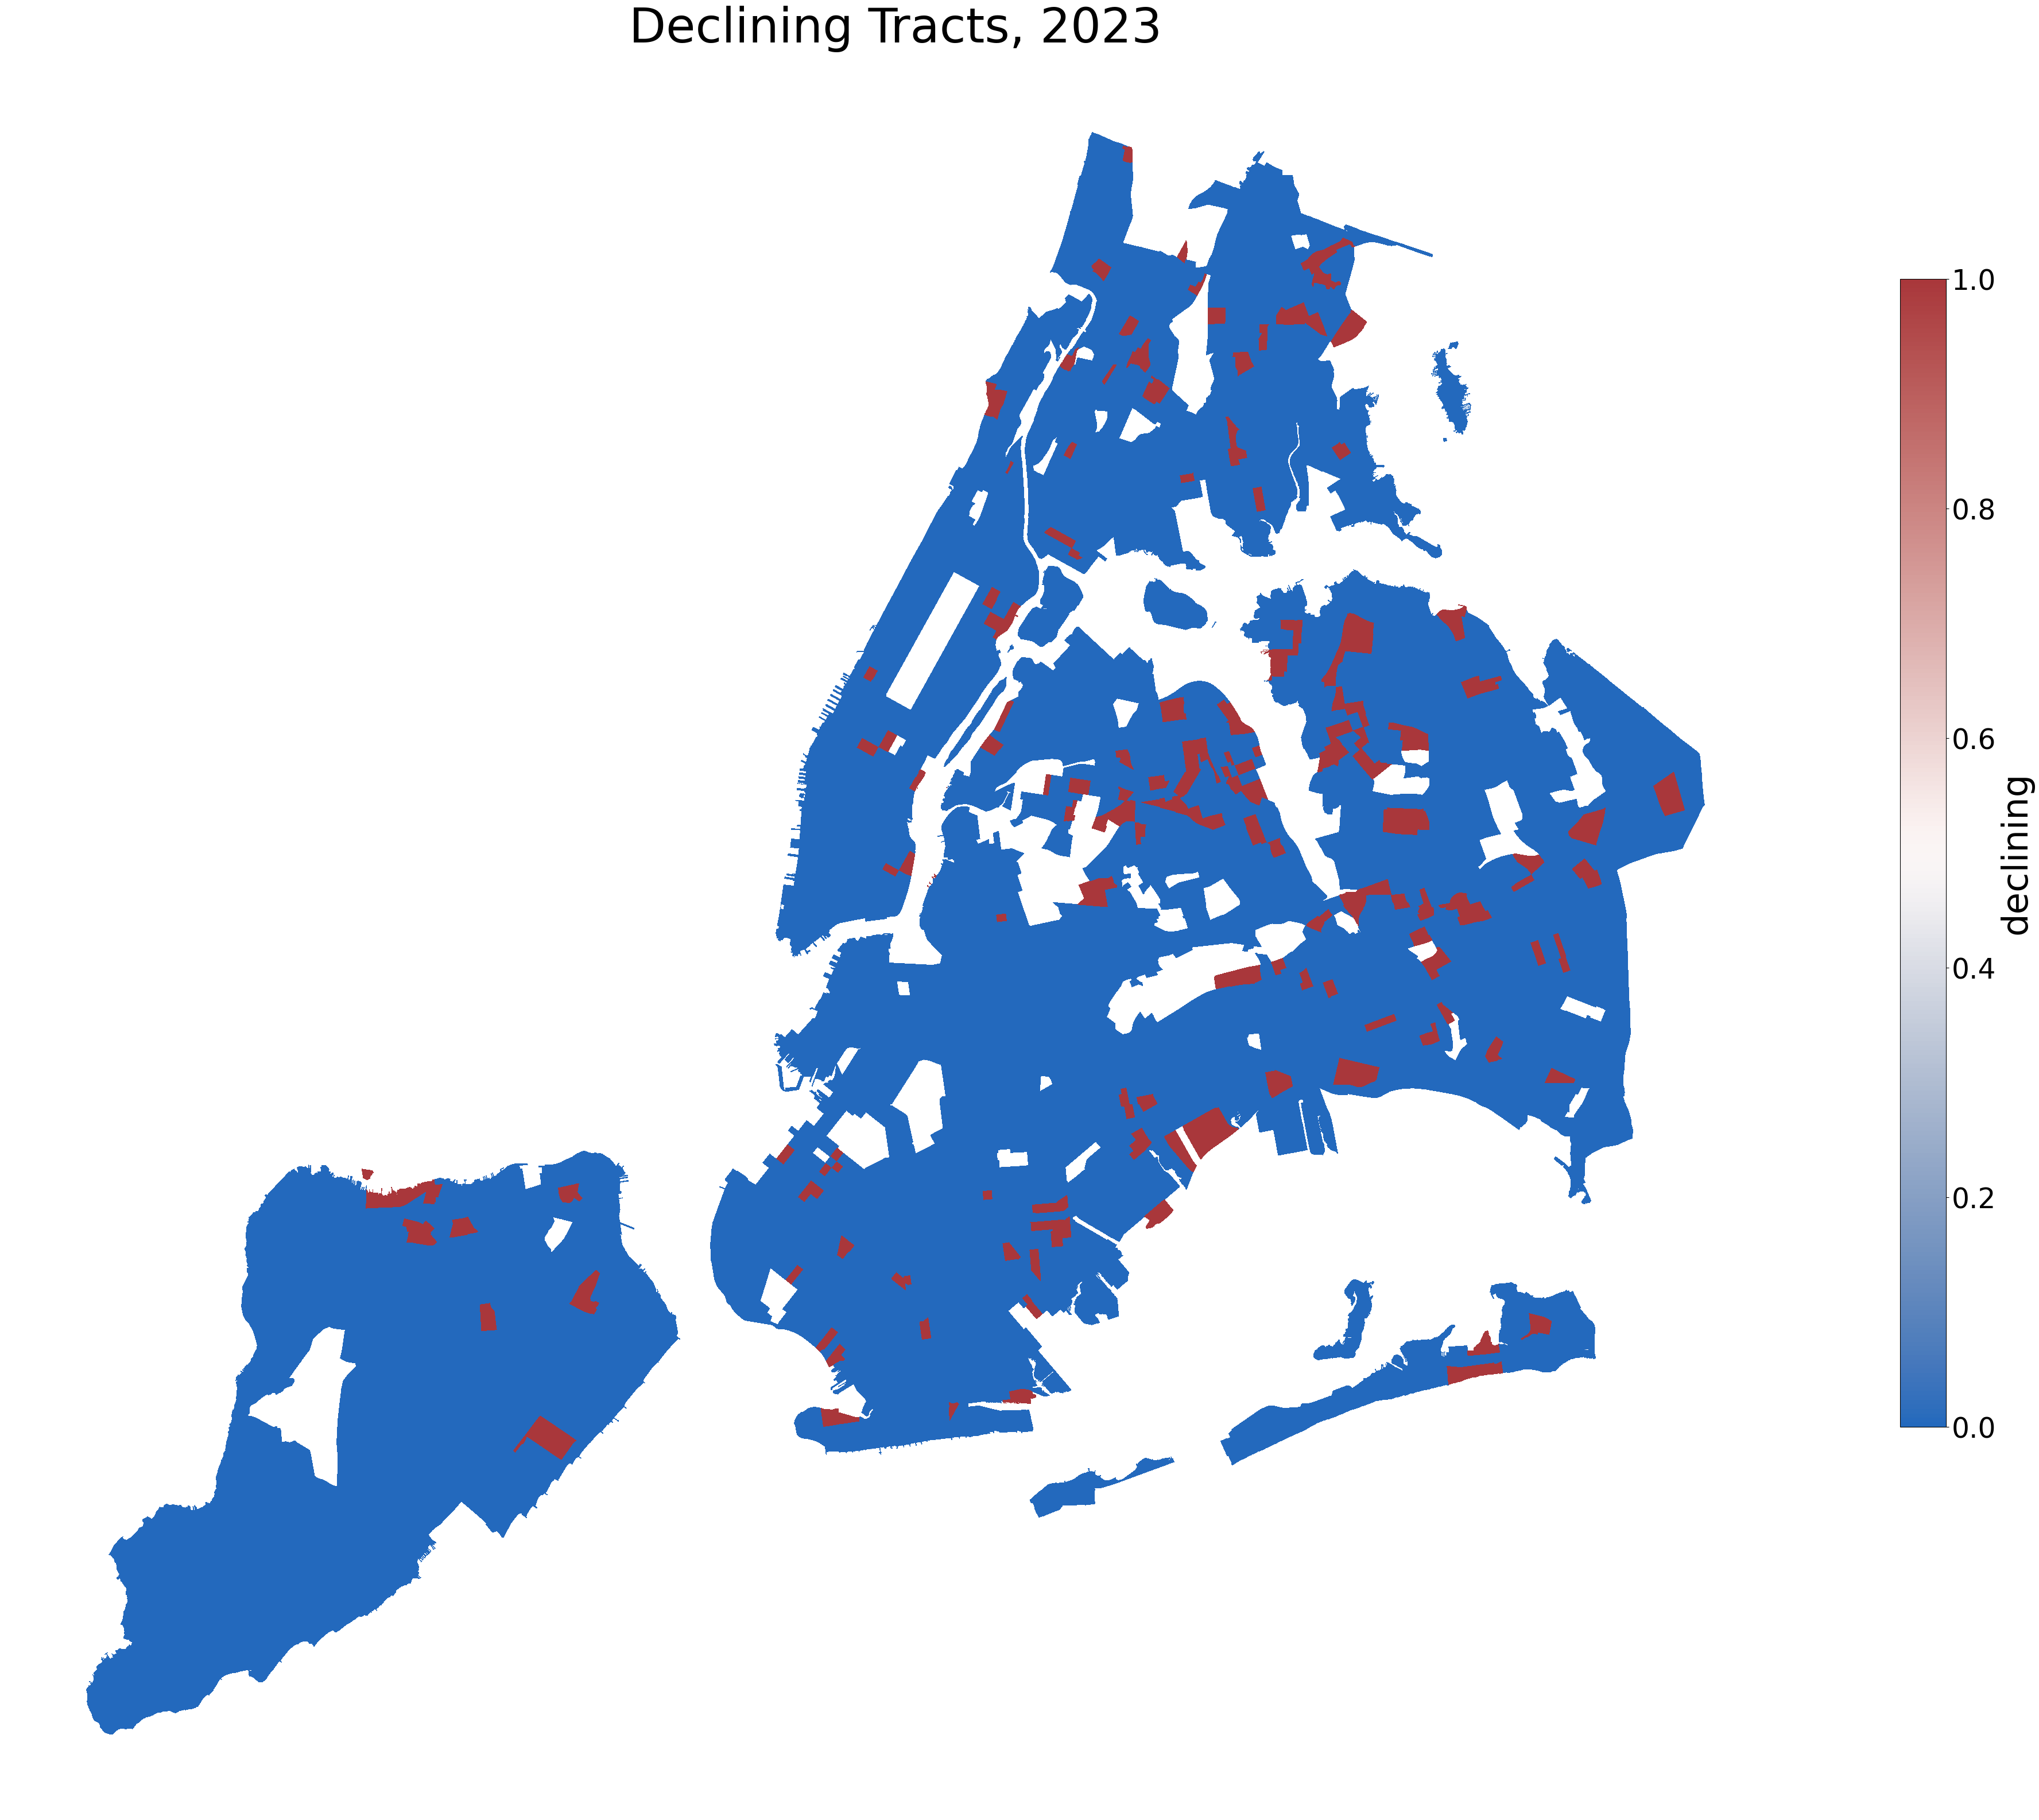

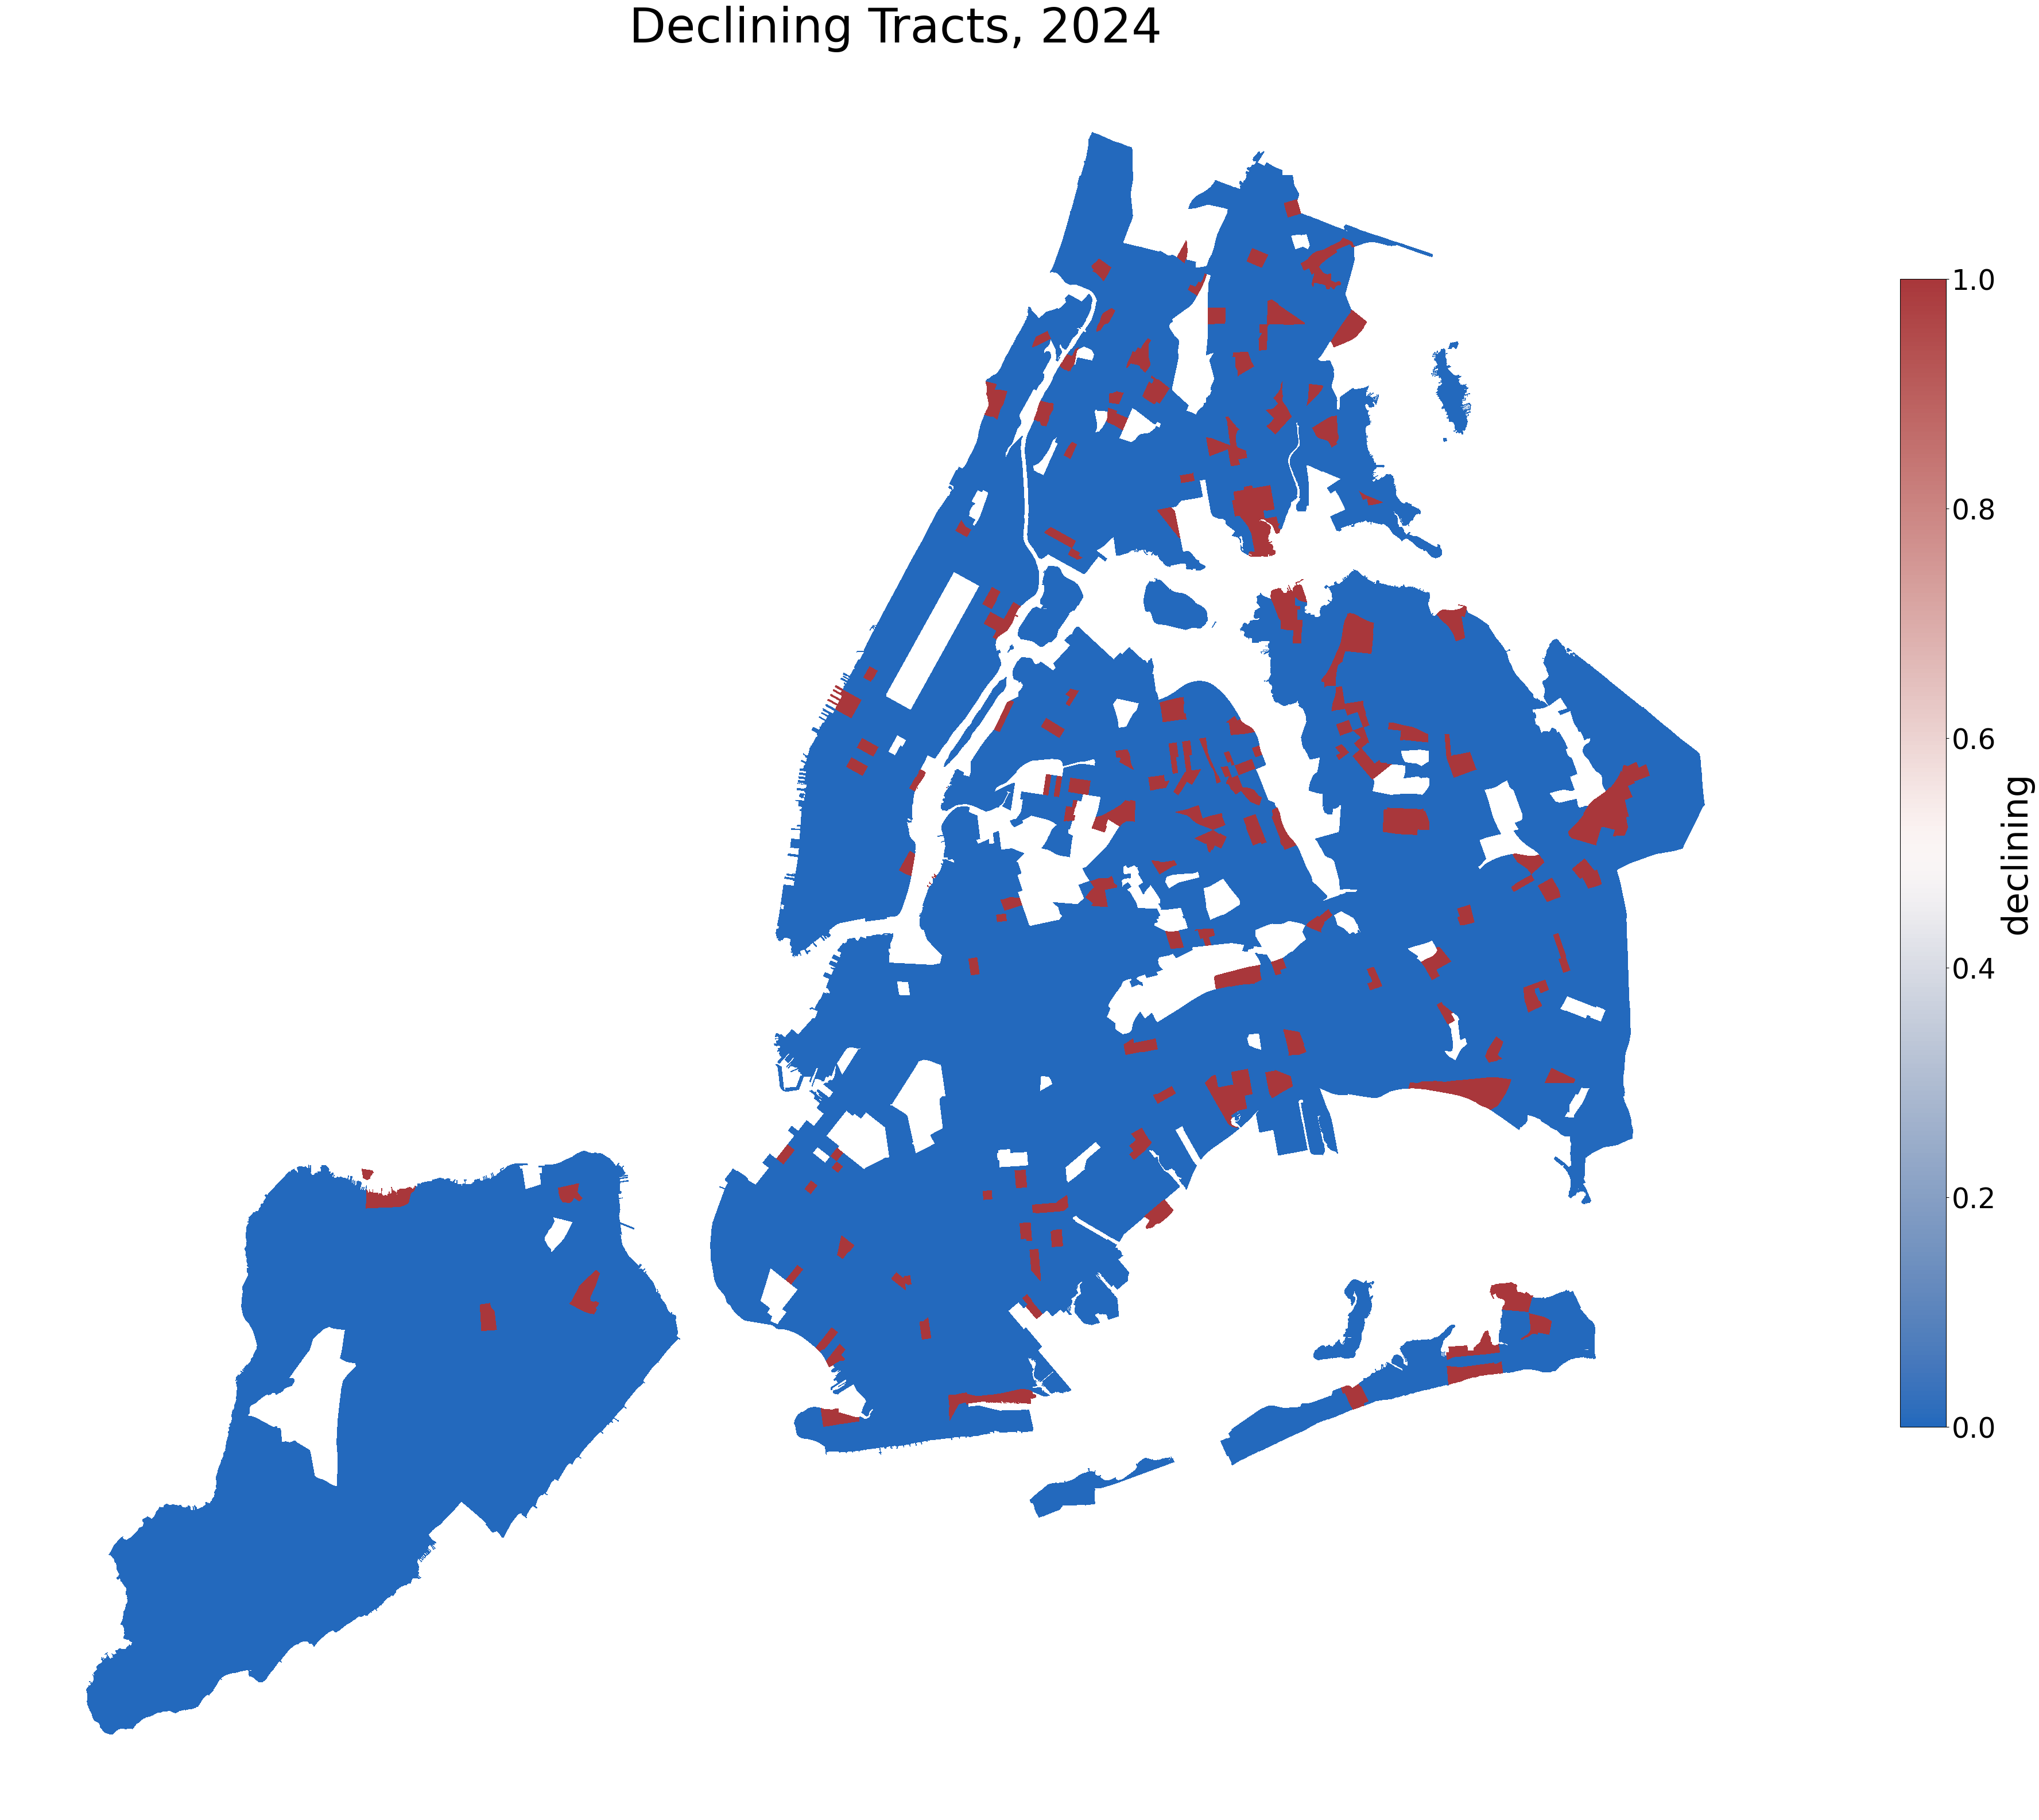

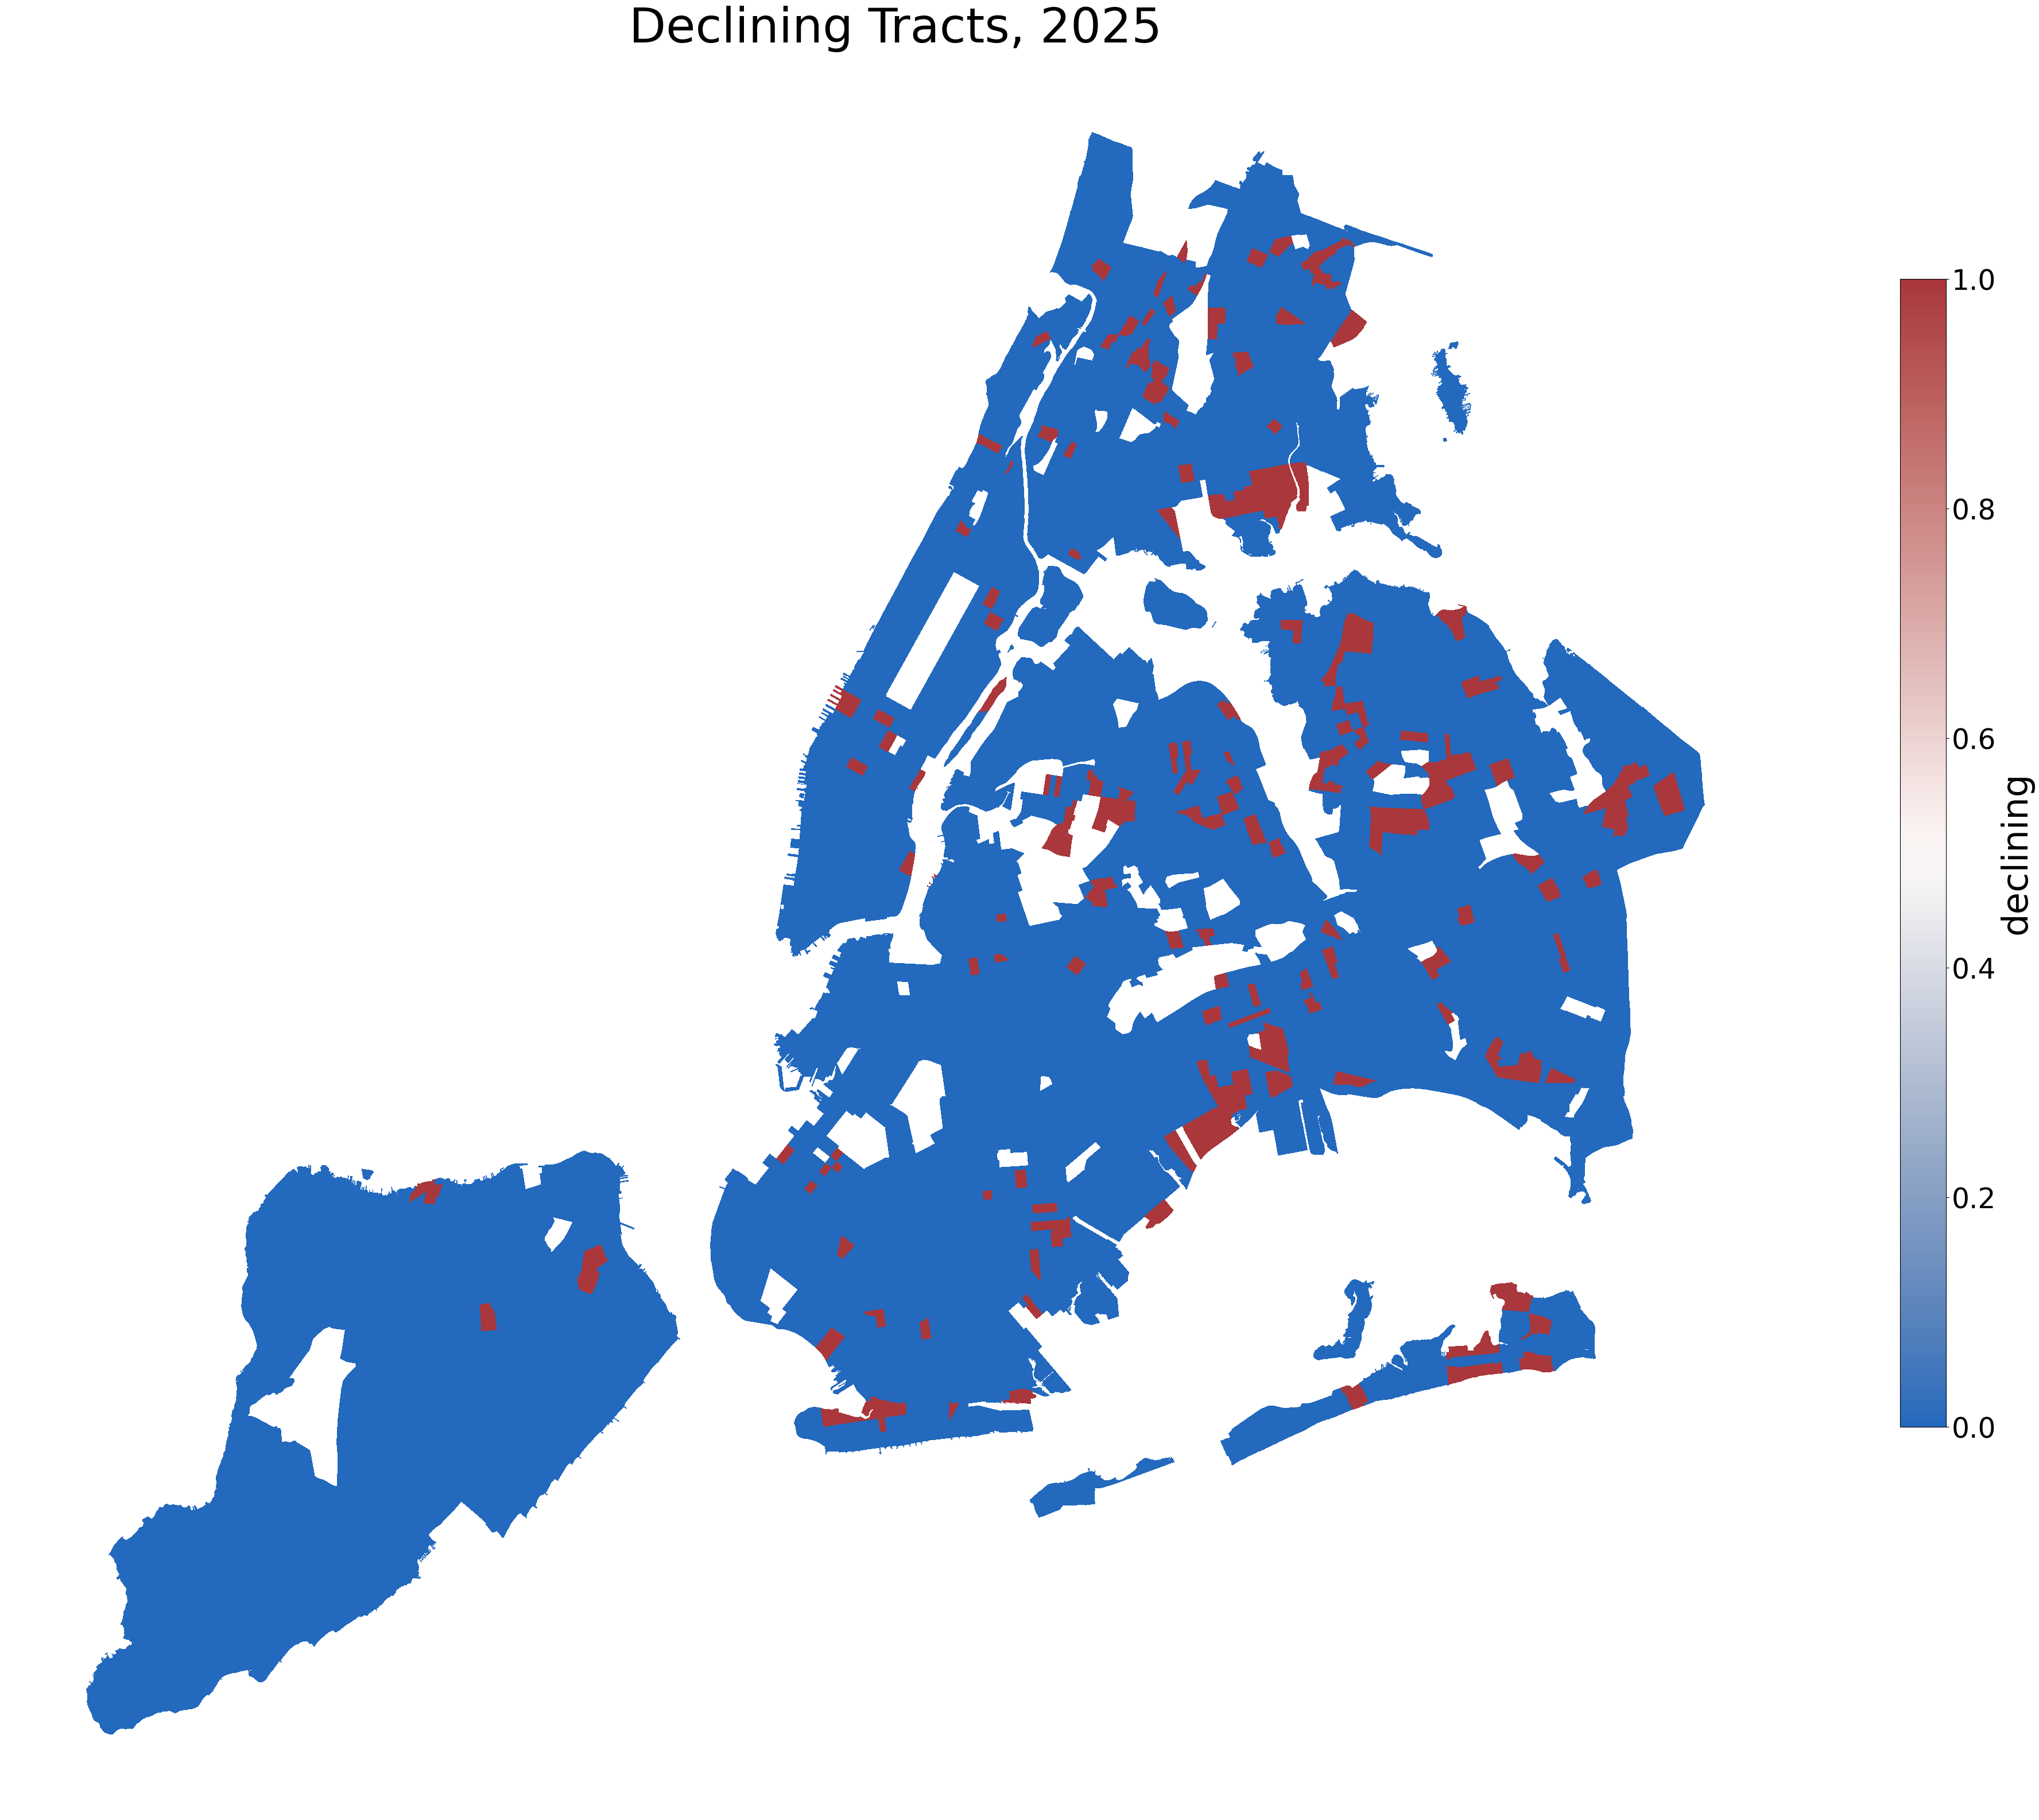

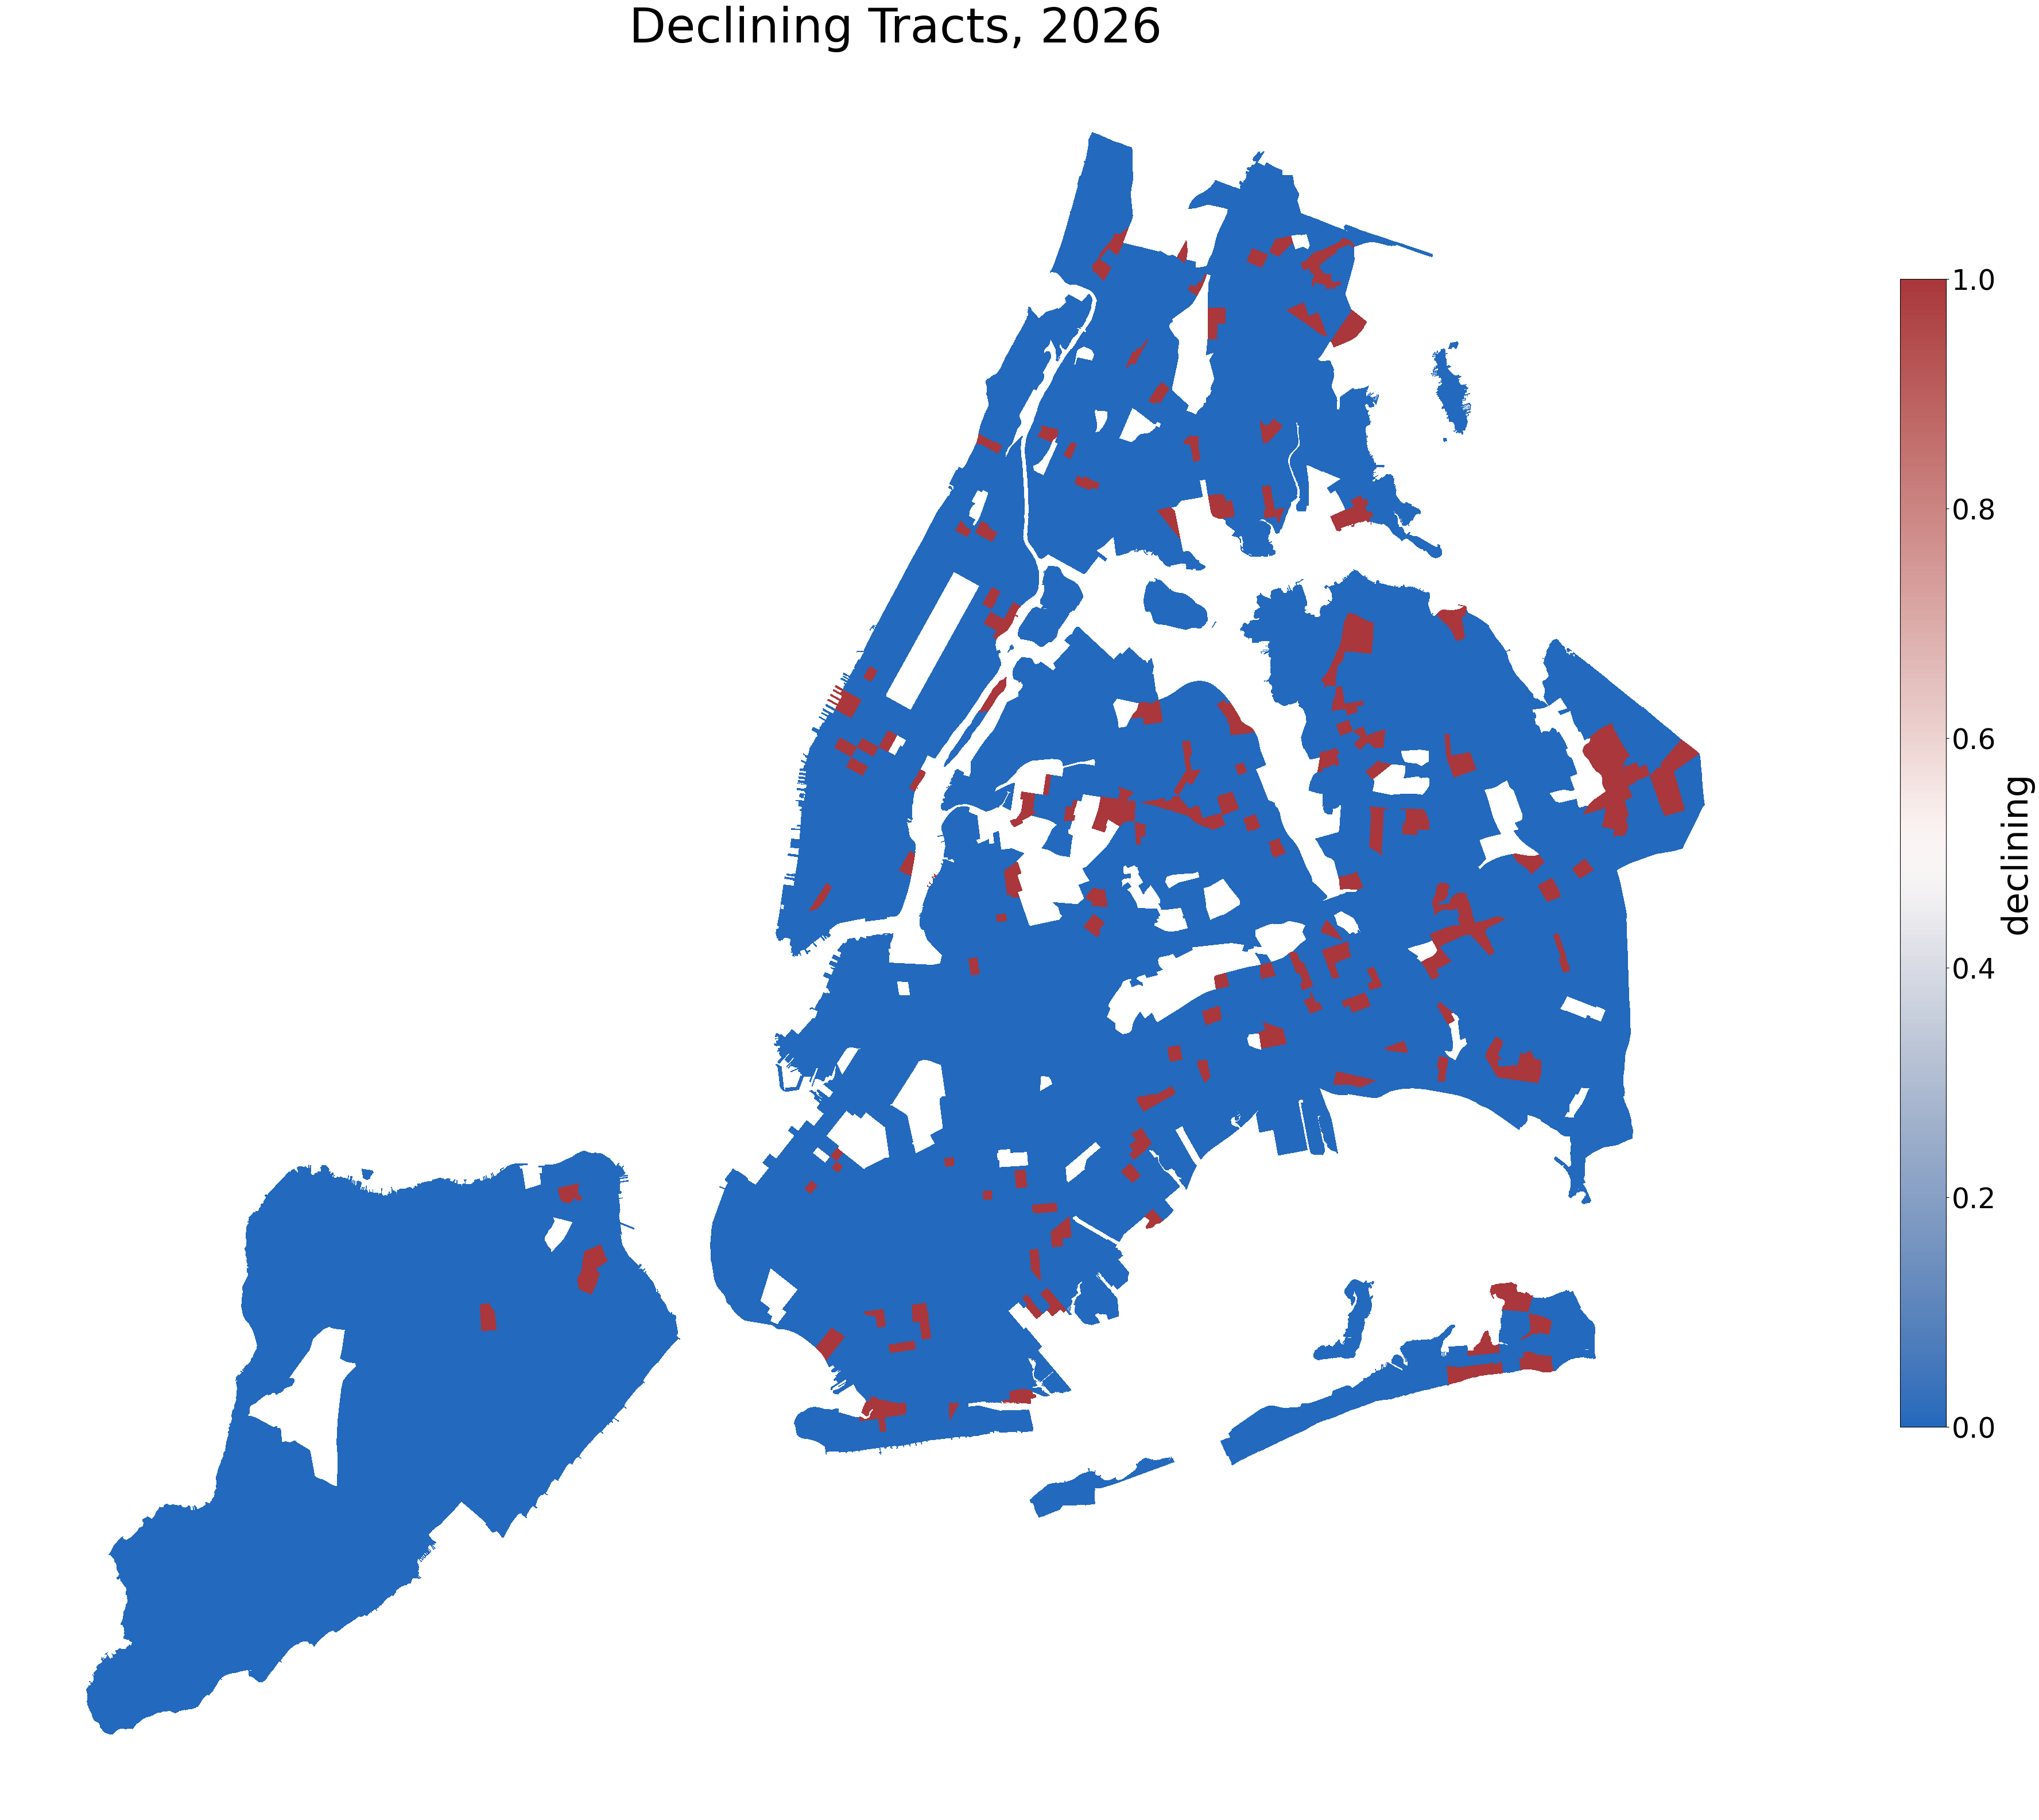

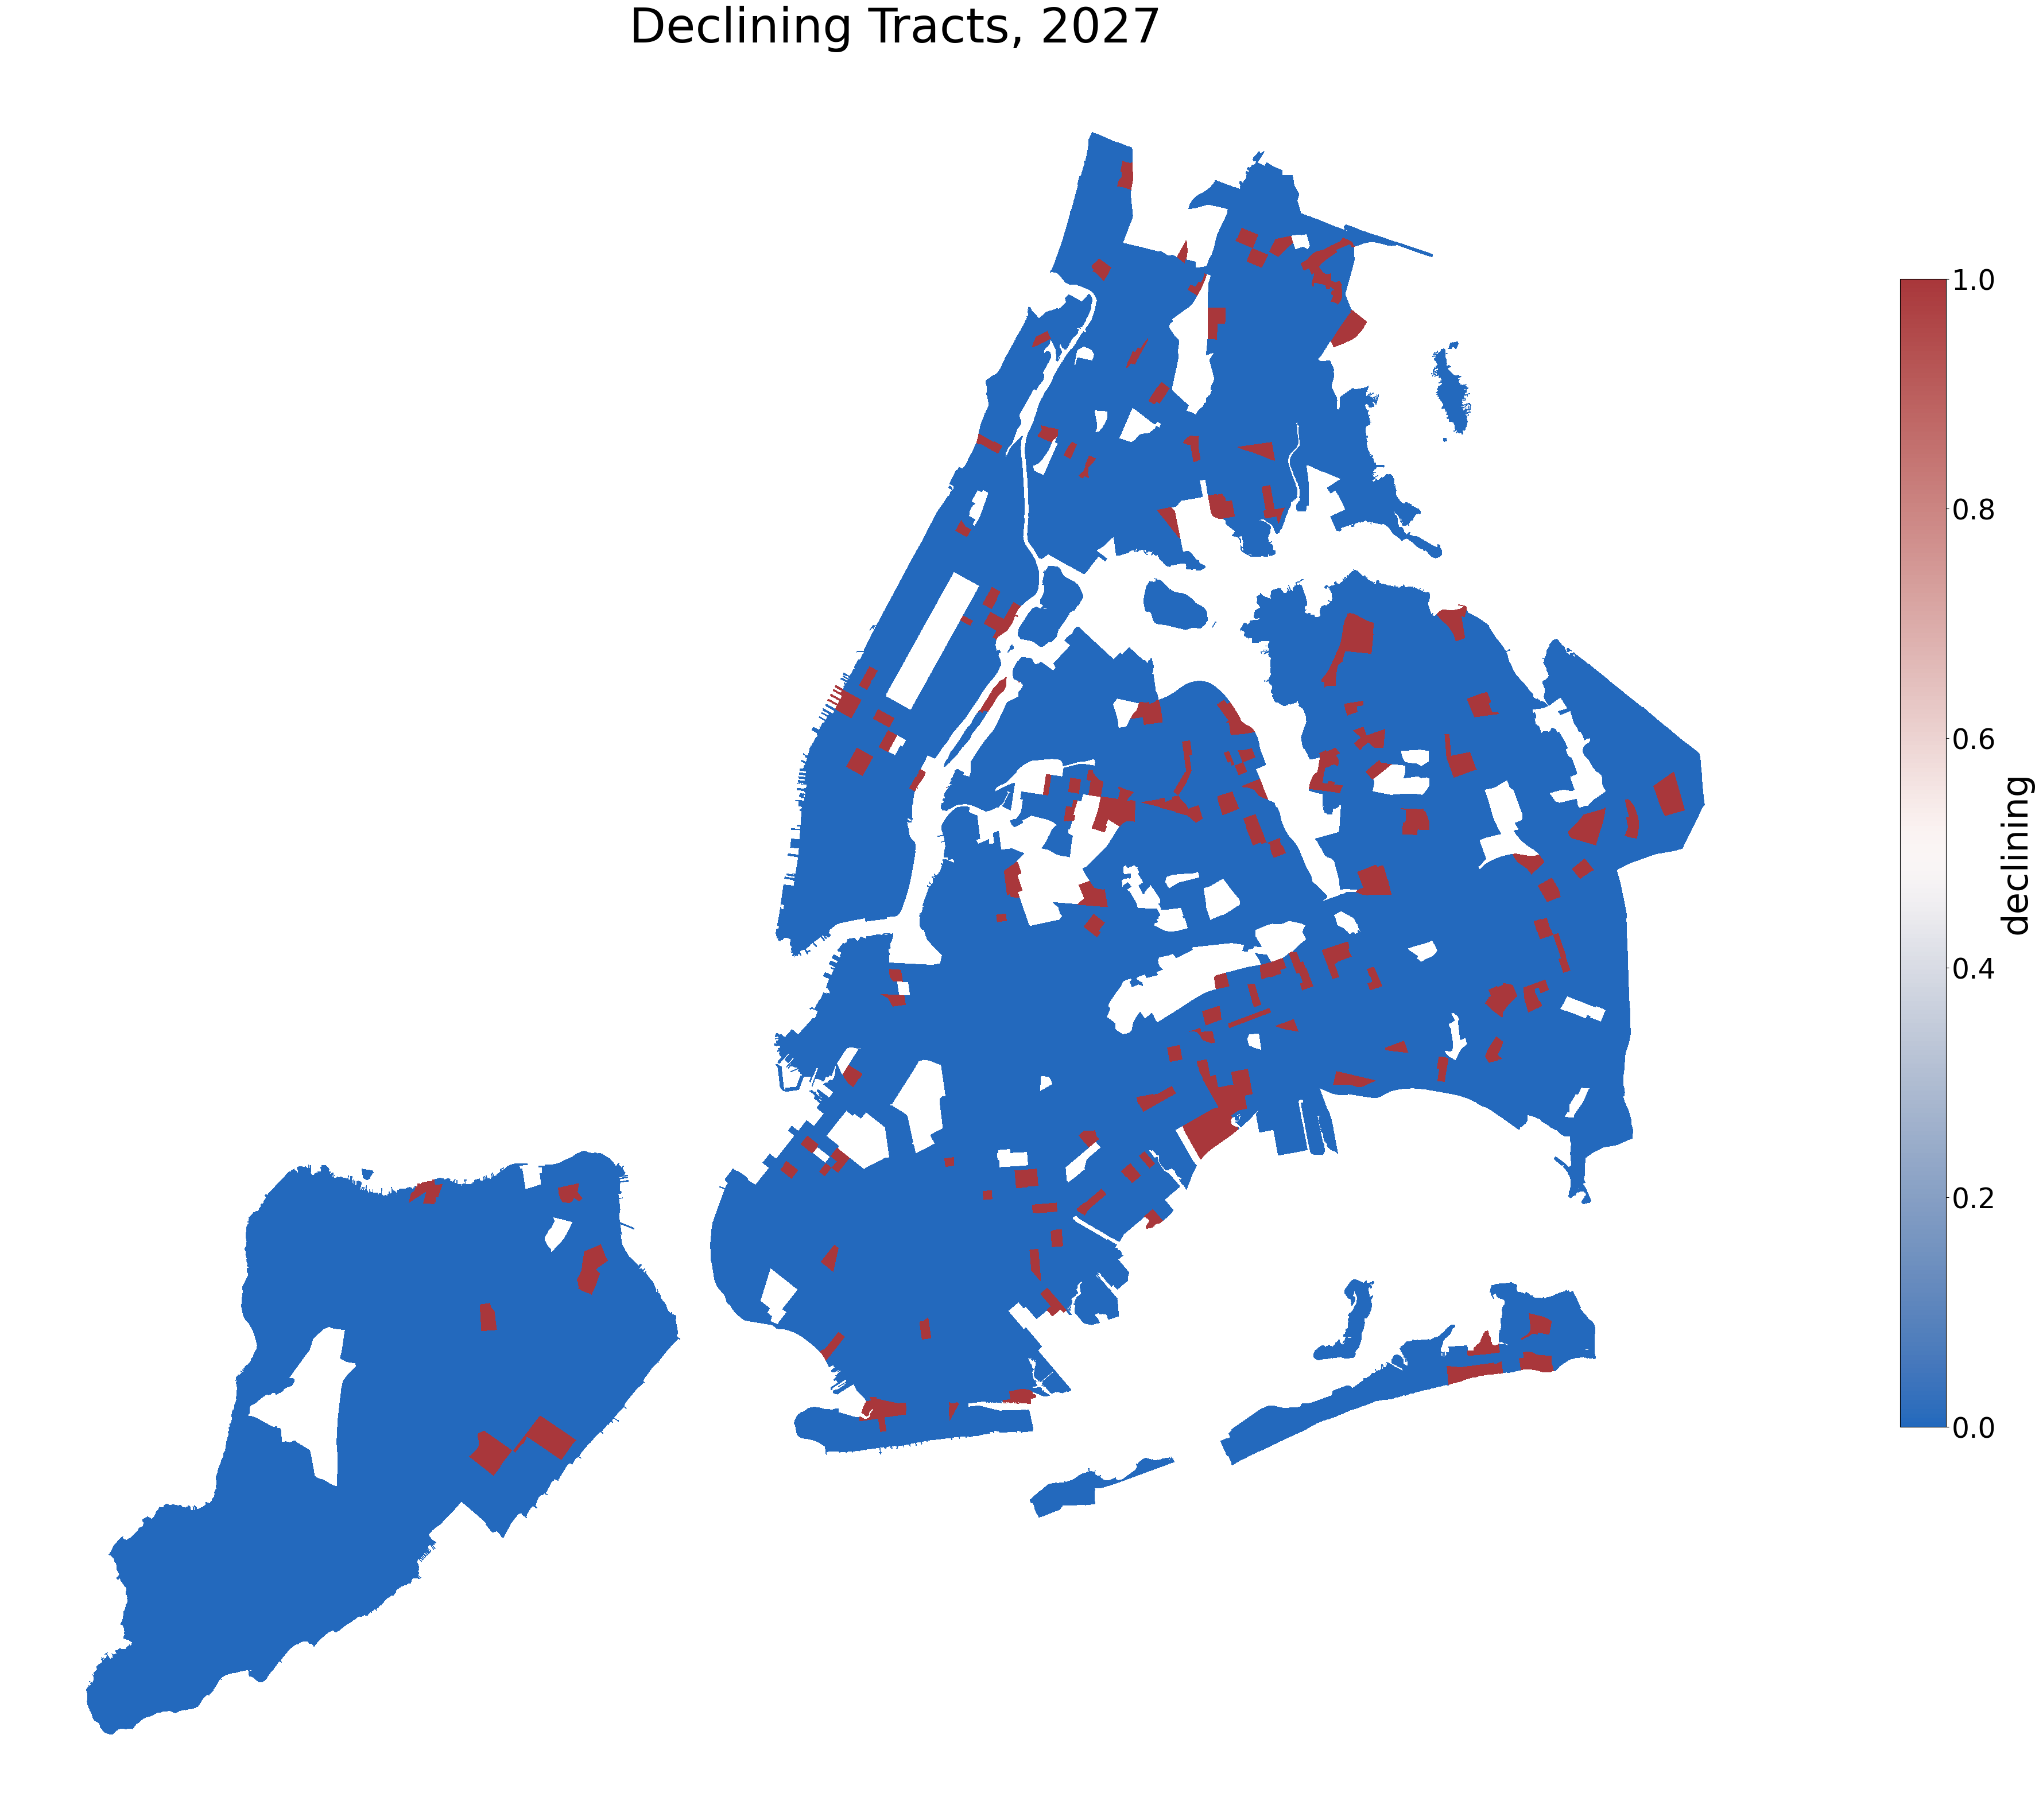

In [198]:
for pred_year in ['2020','2021','2022','2023','2024','2025','2026','2027']:
    df_displaced = find_declining_tracts(df, pred_year)
    # visualize
    choropleth(df_displaced, 'declining', [pred_year], cmap='vlag', title='Declining Tracts', save_img=True)


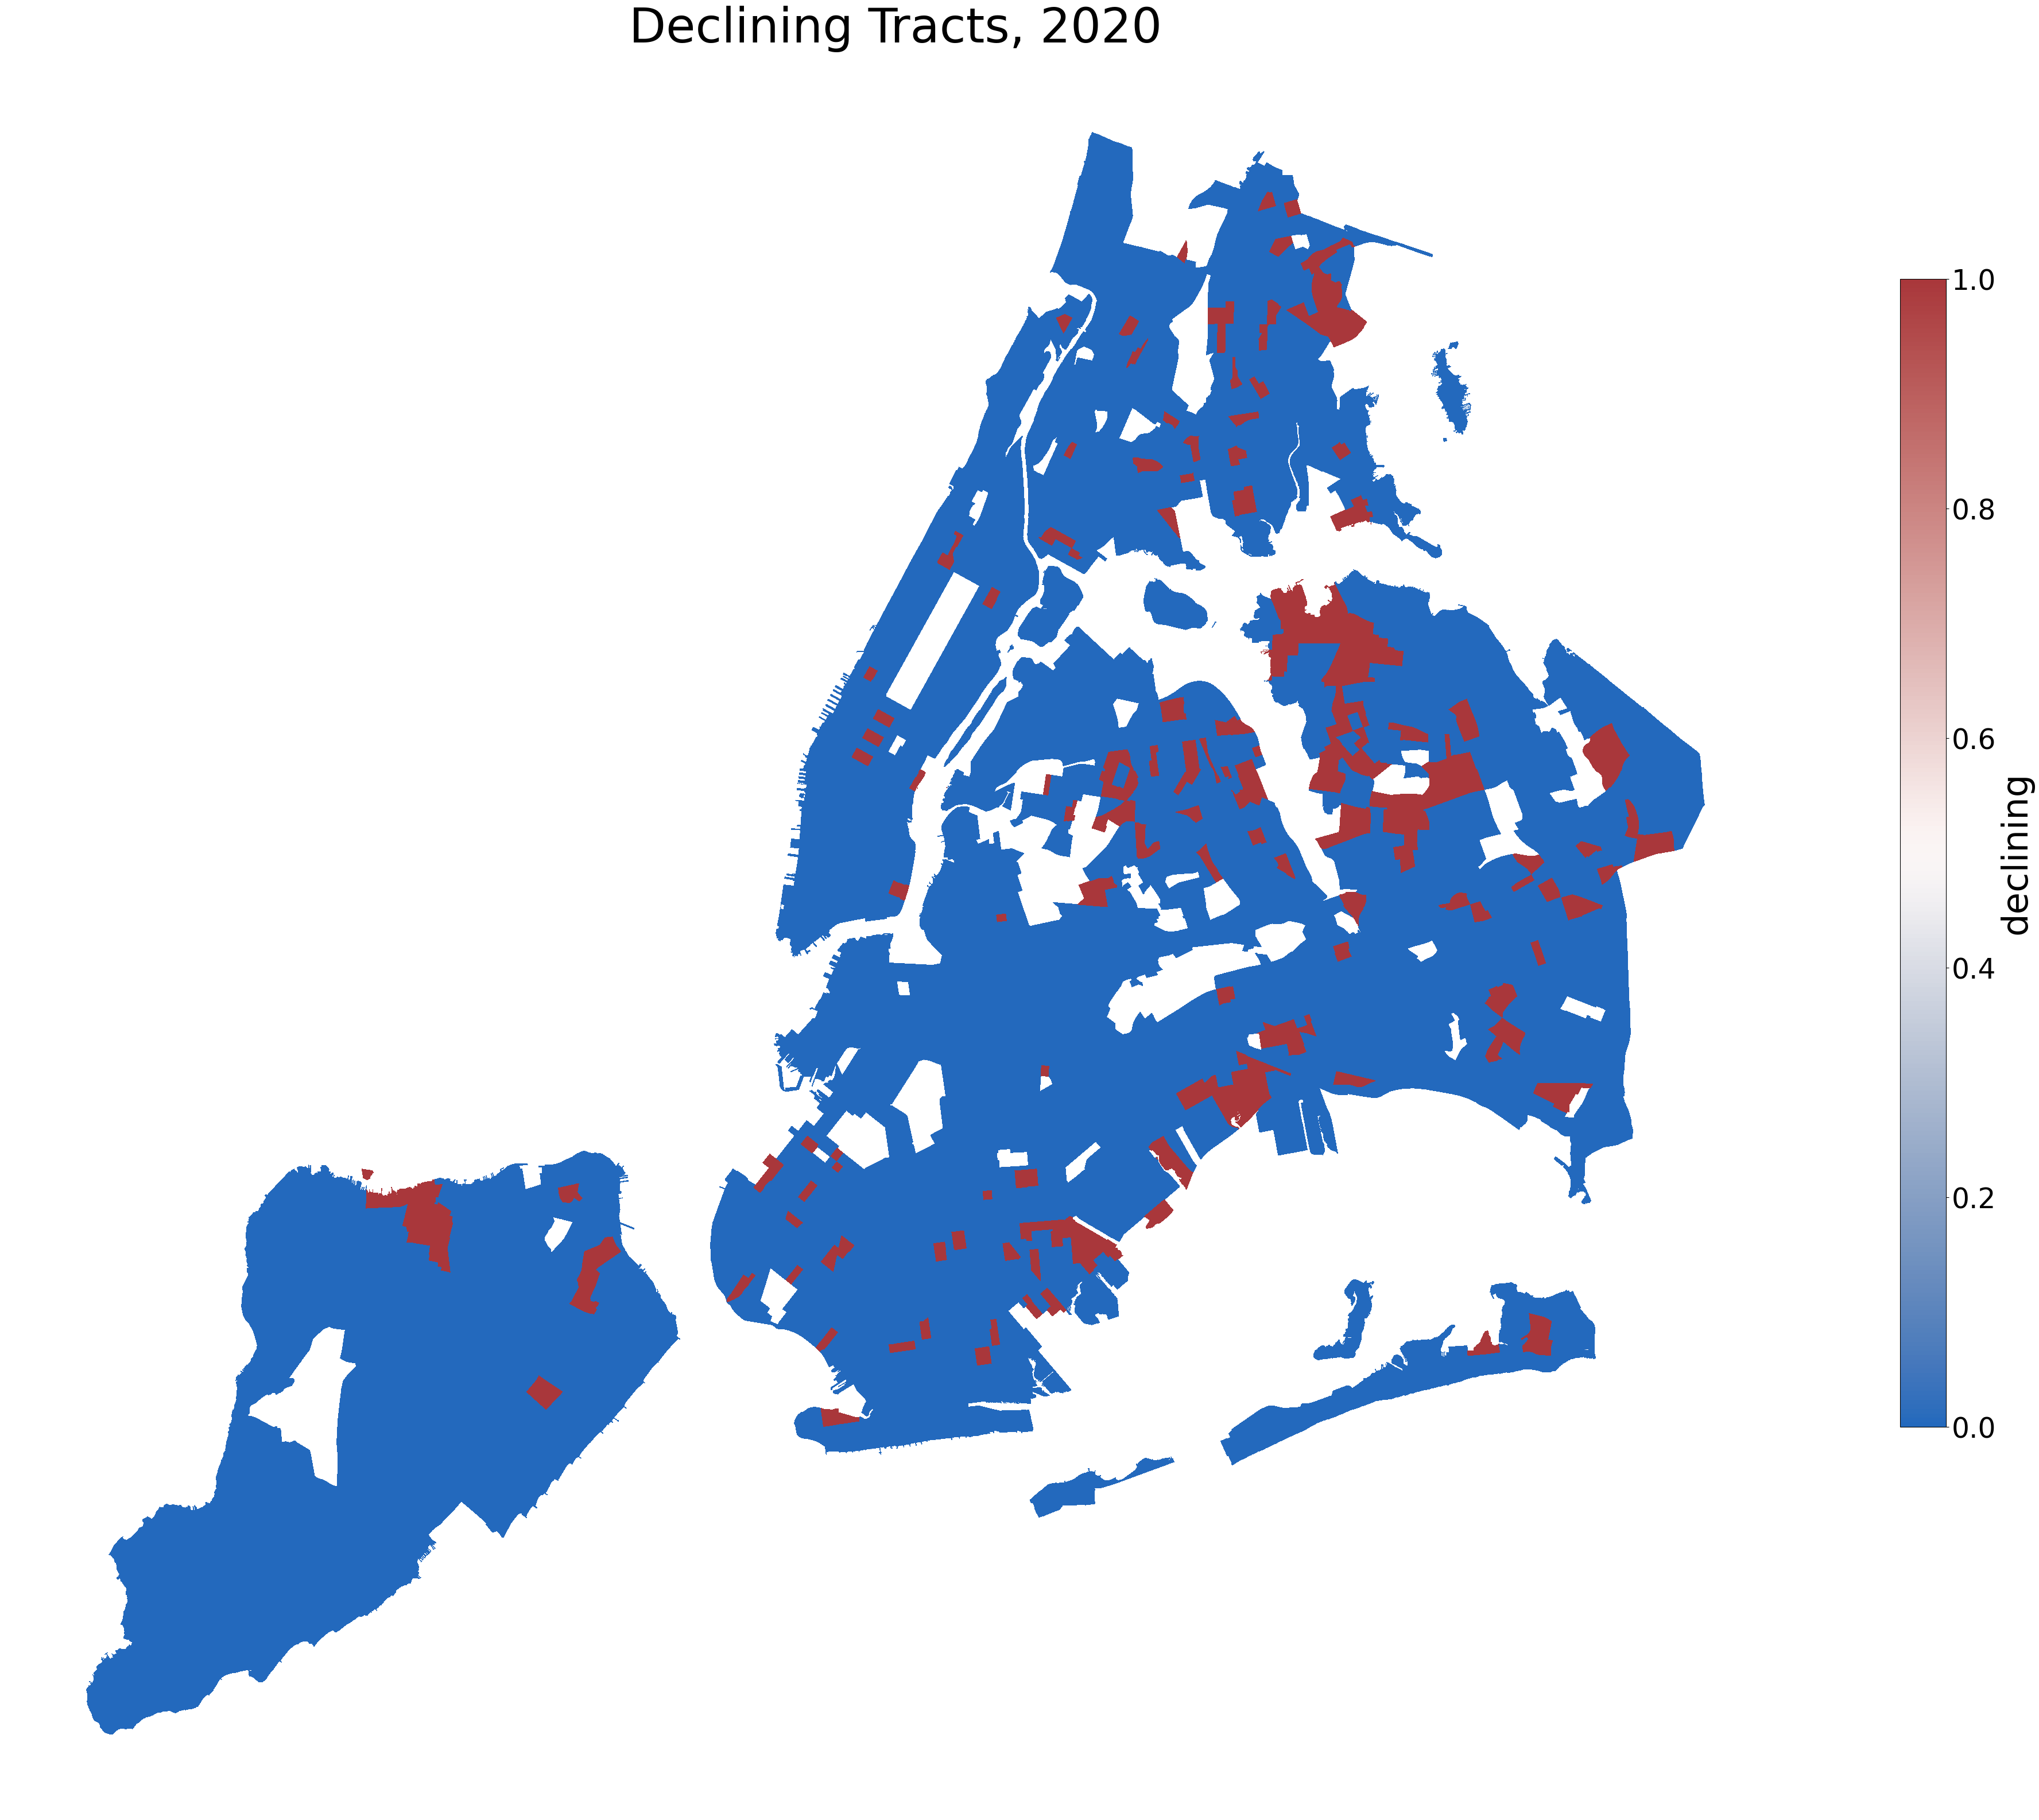